In [ ]:
!pip install -q torch_optimizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 65.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 76.6 MB/s eta 0:00:00


In [ ]:
!pip install -q seedbank

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.8/87.8 kB 8.3 MB/s eta 0:00:00


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch_optimizer as optim_extra

import matplotlib.pyplot as plt
import pandas as pd
import time
import random
import numpy as np

In [ ]:
import seedbank

seedbank.initialize(42)

SeedSequence(
    entropy=42,
)

## Загрузка данных


In [ ]:
!mkdir -p ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"","key":	""}
import json
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(api_token, f)

!chmod 600 ~/.kaggle/kaggle.json
!cat ~/.kaggle/kaggle.json

!kaggle datasets download -d alessiocorrado99/animals10
!unzip -q animals10.zip

{"username": "", "key": ""}Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
 97% 570M/586M [00:06<00:00, 50.2MB/s]
100% 586M/586M [00:06<00:00, 91.6MB/s]


In [ ]:
BATCH_SIZE = 64

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

full_dataset = torchvision.datasets.ImageFolder(root='raw-img', transform=transform)
class_names = full_dataset.classes
class_num = len(class_names)

train_val_size = int(0.8 * len(full_dataset))
test_size = len(full_dataset) - train_val_size

generator1 = torch.Generator().manual_seed(42)
train_val_data, test_data = random_split(full_dataset, [train_val_size, test_size], generator=generator1)

train_size = int(0.85 * len(train_val_data))
val_size = len(train_val_data) - train_size

generator2 = torch.Generator().manual_seed(42)
train_data, val_data = random_split(train_val_data, [train_size, val_size], generator=generator2)

train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print(f"\nFull dataset size: {len(full_dataset)} images.")
print(f"Train size: {train_size}")
print(f"Val size: {val_size}")
print(f"Test size: {test_size}")
print(f"Classes ({class_num}): {class_names}")


Full dataset size: 26179 images.
Train size: 17801
Val size: 3142
Test size: 5236
Classes (10): ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


## Модель

In [ ]:
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(16), nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 16 * 16, 512), nn.ReLU(), nn.Dropout(0.5),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
def train_one_epoch(model, optimizer, criterion, train_loader, device):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    return running_loss / len(train_loader)

def evaluate_model(model, test_loader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return 100 * correct / total

In [ ]:
def evaluate_model_detailed(model, test_loader, device):
    all_labels = []
    all_predictions = []

    model.eval()

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)

            all_labels.extend(labels.numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = accuracy_score(all_labels, all_predictions) * 100
    precision = precision_score(all_labels, all_predictions, average='macro', zero_division=0) * 100
    recall = recall_score(all_labels, all_predictions, average='macro', zero_division=0) * 100
    f1 = f1_score(all_labels, all_predictions, average='macro', zero_division=0) * 100

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1
    }

## Подбор гиперпараметров

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Starts on the device: {device}\n")

NUM_EPOCHS = 8
lr_list = [0.01, 0.001]
batch_list = [32, 64, 128]

optimizers = {"SGD": optim.SGD, "Adam": optim.Adam, "LAMB": optim_extra.Lamb}
criterion = nn.CrossEntropyLoss()

best_params_for_all = {}

for name, optimizer_class in optimizers.items():
    print(f"\n{'='*40}\nSearch params for: {name}\n{'='*40}")

    best_accuracy = 0.0
    best_params = {}

    for batch_size in batch_list:
        train_temp_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
        val_temp_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)

        for lr in lr_list:
            print(f"--- LR={lr}, BS={batch_size} ---")
            model = SimpleCNN(class_num).to(device)

            if name == "SGD":
                optimizer = optimizer_class(model.parameters(), lr=lr, momentum=0.9)
            else:
                optimizer = optimizer_class(model.parameters(), lr=lr)

            for epoch in range(NUM_EPOCHS):
                train_one_epoch(model, optimizer, criterion, train_temp_loader, device)

            val_accuracy = evaluate_model(model, val_temp_loader, device)
            print(f"Val accuracy: {val_accuracy:.2f}%")

            if val_accuracy > best_accuracy:
                best_accuracy = val_accuracy
                best_params = {'lr': lr, 'batch_size': batch_size}

    best_params_for_all[name] = best_params
    print(f"Best params for {name}: {best_params} with accuracy {best_accuracy:.2f}%")


Starts on the device: cuda:0


Search params for: SGD
--- LR=0.01, BS=32 ---
Val accuracy: 64.70%
--- LR=0.001, BS=32 ---
Val accuracy: 70.21%
--- LR=0.01, BS=64 ---
Val accuracy: 67.22%
--- LR=0.001, BS=64 ---
Val accuracy: 67.73%
--- LR=0.01, BS=128 ---
Val accuracy: 68.65%
--- LR=0.001, BS=128 ---
Val accuracy: 65.88%
Best params for SGD: {'lr': 0.001, 'batch_size': 32} with accuracy 70.21%

Search params for: Adam
--- LR=0.01, BS=32 ---
Val accuracy: 17.54%
--- LR=0.001, BS=32 ---
Val accuracy: 65.91%
--- LR=0.01, BS=64 ---
Val accuracy: 17.57%
--- LR=0.001, BS=64 ---
Val accuracy: 68.49%
--- LR=0.01, BS=128 ---
Val accuracy: 18.62%
--- LR=0.001, BS=128 ---
Val accuracy: 68.75%
Best params for Adam: {'lr': 0.001, 'batch_size': 128} with accuracy 68.75%

Search params for: LAMB
--- LR=0.01, BS=32 ---
Val accuracy: 65.31%
--- LR=0.001, BS=32 ---
Val accuracy: 68.68%
--- LR=0.01, BS=64 ---
Val accuracy: 66.33%
--- LR=0.001, BS=64 ---
Val accuracy: 68.46%
--- LR=0.01, BS=128 ---
Val ac

In [ ]:
print("Best params:")

for name, params in best_params_for_all.items():
    print(f"Optimizer {name}: {params}")

Best params:
Optimizer SGD: {'lr': 0.001, 'batch_size': 32}
Optimizer Adam: {'lr': 0.001, 'batch_size': 128}
Optimizer LAMB: {'lr': 0.001, 'batch_size': 32}


# Эксперимент без шума


In [ ]:
def plot_results(results):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

    ax1.set_title("Val accuracy", fontsize=16)
    ax1.set_xlabel("Epoch", fontsize=12)
    ax1.set_ylabel("Accuracy (%)", fontsize=12)

    for name, res in results.items():
        ax1.plot(res['accuracy'], label=name, marker='o', linestyle='--')
    ax1.legend()
    ax1.grid(True)

    ax2.set_title("Train loss", fontsize=16)
    ax2.set_xlabel("Epoch", fontsize=12)
    ax2.set_ylabel("Loss", fontsize=12)

    for name, res in results.items():
        ax2.plot(res['loss'], label=name, marker='o', linestyle='--')
    ax2.legend()
    ax2.grid(True)

    plt.suptitle("Comparison of optimizers", fontsize=20)
    plt.show()

In [ ]:
import time

def run_simple_experiment(cnn_model, class_num, epoch_number, lr, train_loader, val_loader, criterion, target_loss = 0.3):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Experiment starts on the device: {device}\n")

    results = {}

    optimizers_to_test = {"SGD": optim.SGD, "Adam": optim.Adam, "LAMB": optim_extra.Lamb}

    for name, optimizer_class in optimizers_to_test.items():
        print(f"\n{'='*30}\nTraining with: {name}\n{'='*30}")

        model = cnn_model(class_num).to(device)

        if name == "SGD":
            optimizer = optimizer_class(model.parameters(), lr, momentum=0.9)
        else:
            optimizer = optimizer_class(model.parameters(), lr)

        history_loss, history_val_accuracy = [], []
        convergence_time = -1

        start_time = time.time()

        for epoch in range(epoch_number):
            epoch_loss = train_one_epoch(model, optimizer, criterion, train_loader, device)
            val_accuracy = evaluate_model(model, val_loader, device)

            history_loss.append(epoch_loss)
            history_val_accuracy.append(val_accuracy)

            if epoch_loss <= target_loss and convergence_time == -1:
                convergence_time = time.time() - start_time
                print(f"---Сonvergence was achieved in {convergence_time:.2f} seconds at {epoch + 1} epoch---")

            print(f"Epoch [{epoch+1:2d}/{epoch_number}], Train loss: {epoch_loss:.4f}, Val accuracy: {val_accuracy:.2f}%")

        results[name] = {
            "accuracy": history_val_accuracy,
            "loss": history_loss,
            "final_accuracy": val_accuracy,
            "model_state": model.state_dict(),
            "convergence_time": convergence_time
        }

    return results, device


In [ ]:
EPOCH_NUMBER = 12
LEARNING_RATE = 0.001
TARGET_LOSS = 0.4

criterion = nn.CrossEntropyLoss()

results, device = run_simple_experiment(SimpleCNN, class_num, EPOCH_NUMBER, LEARNING_RATE, train_loader, val_loader, criterion, TARGET_LOSS)

Experiment starts on the device: cuda:0


Training with: SGD
Epoch [ 1/12], Train loss: 1.6427, Val accuracy: 54.39%
Epoch [ 2/12], Train loss: 1.2296, Val accuracy: 59.33%
Epoch [ 3/12], Train loss: 1.0232, Val accuracy: 59.74%
Epoch [ 4/12], Train loss: 0.8433, Val accuracy: 63.62%
Epoch [ 5/12], Train loss: 0.6671, Val accuracy: 65.44%
Epoch [ 6/12], Train loss: 0.5073, Val accuracy: 67.06%
---Сonvergence was achieved in 305.26 seconds at 7 epoch---
Epoch [ 7/12], Train loss: 0.3843, Val accuracy: 68.46%
Epoch [ 8/12], Train loss: 0.2654, Val accuracy: 68.43%
Epoch [ 9/12], Train loss: 0.1783, Val accuracy: 68.75%
Epoch [10/12], Train loss: 0.1285, Val accuracy: 68.27%
Epoch [11/12], Train loss: 0.0944, Val accuracy: 69.16%
Epoch [12/12], Train loss: 0.0718, Val accuracy: 69.13%

Training with: Adam
Epoch [ 1/12], Train loss: 1.9457, Val accuracy: 46.79%
Epoch [ 2/12], Train loss: 1.4575, Val accuracy: 60.22%
Epoch [ 3/12], Train loss: 1.2192, Val accuracy: 62.95%
Epoch [ 4/12], Tra

In [ ]:
for name, res_dict in results.items():
    final_model = SimpleCNN(class_num).to(device)
    final_model.load_state_dict(res_dict["model_state"])

    test_accuracy = evaluate_model(final_model, test_loader, device)

    results[name]['test_accuracy'] = test_accuracy

    print(f"Test accuracy for {name}: {test_accuracy:.2f}%")


Test accuracy for SGD: 69.23%
Test accuracy for Adam: 69.40%
Test accuracy for LAMB: 67.00%


In [ ]:
print(f"{'Optimizer':<10} | {'Val Acc (%)':<25} | {'Test Acc (%)':<25} | {'Convergence_time (s)':<20}")
print("-" * 90)

for name, res in results.items():
    val_acc = res['final_accuracy']
    test_acc = res.get('test_accuracy', 'N/A')
    conv_time = res['convergence_time']

    print(f"{name:<10} | {val_acc:<25.2f} | {test_acc:<25.2f} | {conv_time:<20.2f}")


Optimizer  | Val Acc (%)               | Test Acc (%)              | Convergence_time (s)
------------------------------------------------------------------------------------------
SGD        | 69.13                     | 69.23                     | 305.26              
Adam       | 68.36                     | 69.40                     | 394.78              
LAMB       | 66.61                     | 67.00                     | 355.45              


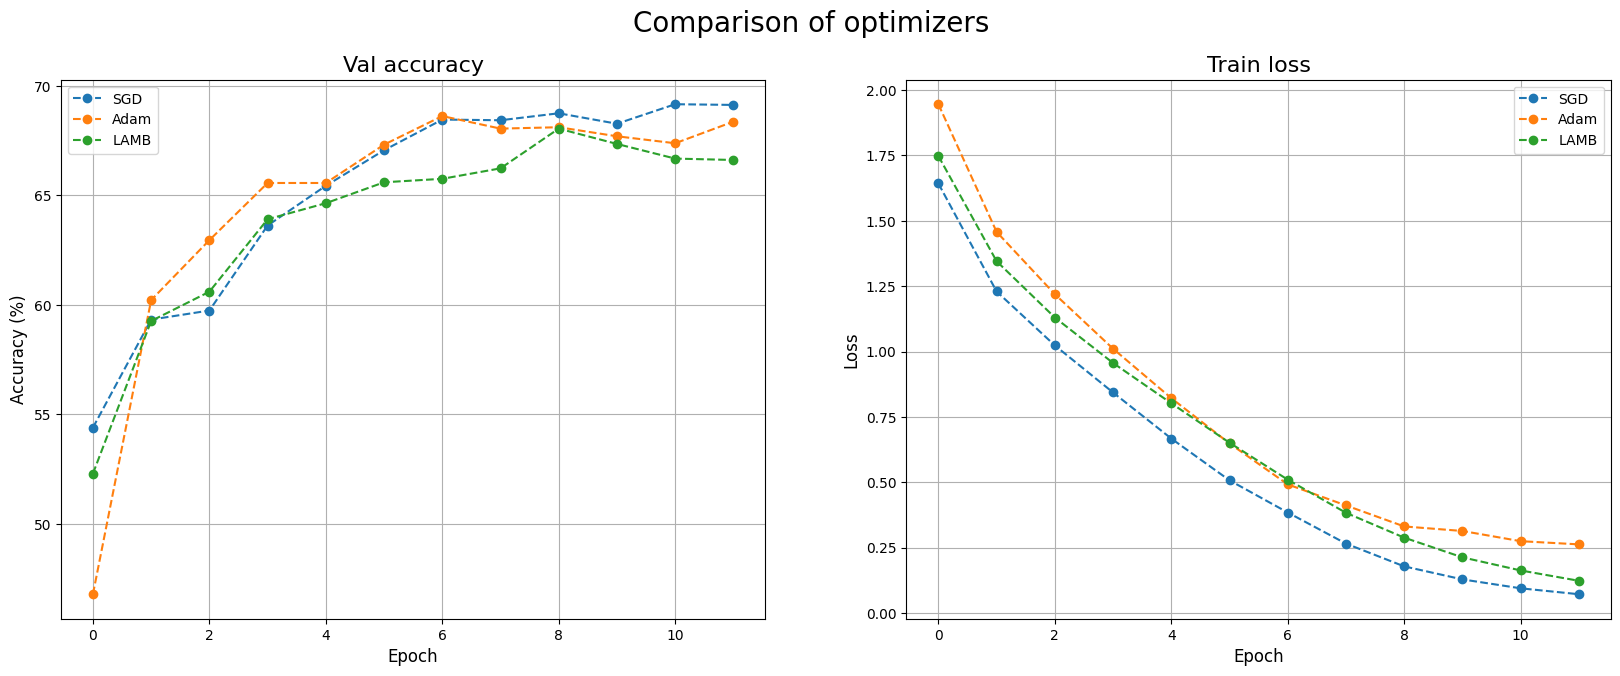

In [ ]:
plot_results(results)

# Эксперименты с шумом


## Виды шума

In [ ]:
class GaussianNoiseAdder(object):
    def __init__(self, mean=0., std=0.1):
        self.std = std
        self.mean = mean

    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean

    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

In [ ]:
class SaltAndPepperNoiseAdder(object):
    def __init__(self, amount=0.04):
        self.amount = amount

    def __call__(self, tensor):
        noisy_tensor = tensor.clone()
        c, h, w = noisy_tensor.size()

        num_noise_pixels = int(self.amount * h * w)

        salt_coords = [torch.randint(0, d-1, (num_noise_pixels // 2,)) for d in (h, w)]
        noisy_tensor[:, salt_coords[0], salt_coords[1]] = 1.0

        pepper_coords = [torch.randint(0, d-1, (num_noise_pixels // 2,)) for d in (h, w)]
        noisy_tensor[:, pepper_coords[0], pepper_coords[1]] = 0.0

        return noisy_tensor

    def __repr__(self):
        return self.__class__.__name__ + f'(amount={self.amount})'

In [ ]:
def unnormalize(tensor, mean, std):
    tensor = tensor.clone()

    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)
    return tensor

In [ ]:
def visualize_noise_examples(clean_loader, num_images=3):
    gaussian_levels = [0.05, 0.1, 0.15]
    salt_pepper_levels = [0.02, 0.05, 0.08]

    images, _ = next(iter(clean_loader))

    for i in range(num_images):
        if i >= len(images):
            break

        clean_tensor_normalized = images[i]
        clean_tensor = unnormalize(clean_tensor_normalized, mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))

        fig, axes = plt.subplots(2, 4, figsize=(20, 10))
        fig.suptitle(f"Image №{i+1}", fontsize=20)

        axes[0, 0].imshow(np.clip(clean_tensor.permute(1, 2, 0), 0, 1))
        axes[0, 0].set_title("Original (Clean)")
        axes[0, 0].axis('off')

        for j, std in enumerate(gaussian_levels):
            add_gaussian = GaussianNoiseAdder(std)
            gaussian_tensor = add_gaussian(clean_tensor.clone())

            ax = axes[0, j + 1]
            ax.imshow(np.clip(gaussian_tensor.permute(1, 2, 0), 0, 1))
            ax.set_title(f"Gaussian (std={std})")
            ax.axis('off')

        for j, amount in enumerate(salt_pepper_levels):
            add_salt_pepper = SaltAndPepperNoiseAdder(amount)
            sp_tensor = add_salt_pepper(clean_tensor.clone())

            ax = axes[1, j + 1]
            ax.imshow(np.clip(sp_tensor.permute(1, 2, 0), 0, 1))
            ax.set_title(f"Salt & Pepper (amount={amount})")
            ax.axis('off')

        axes[1, 0].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

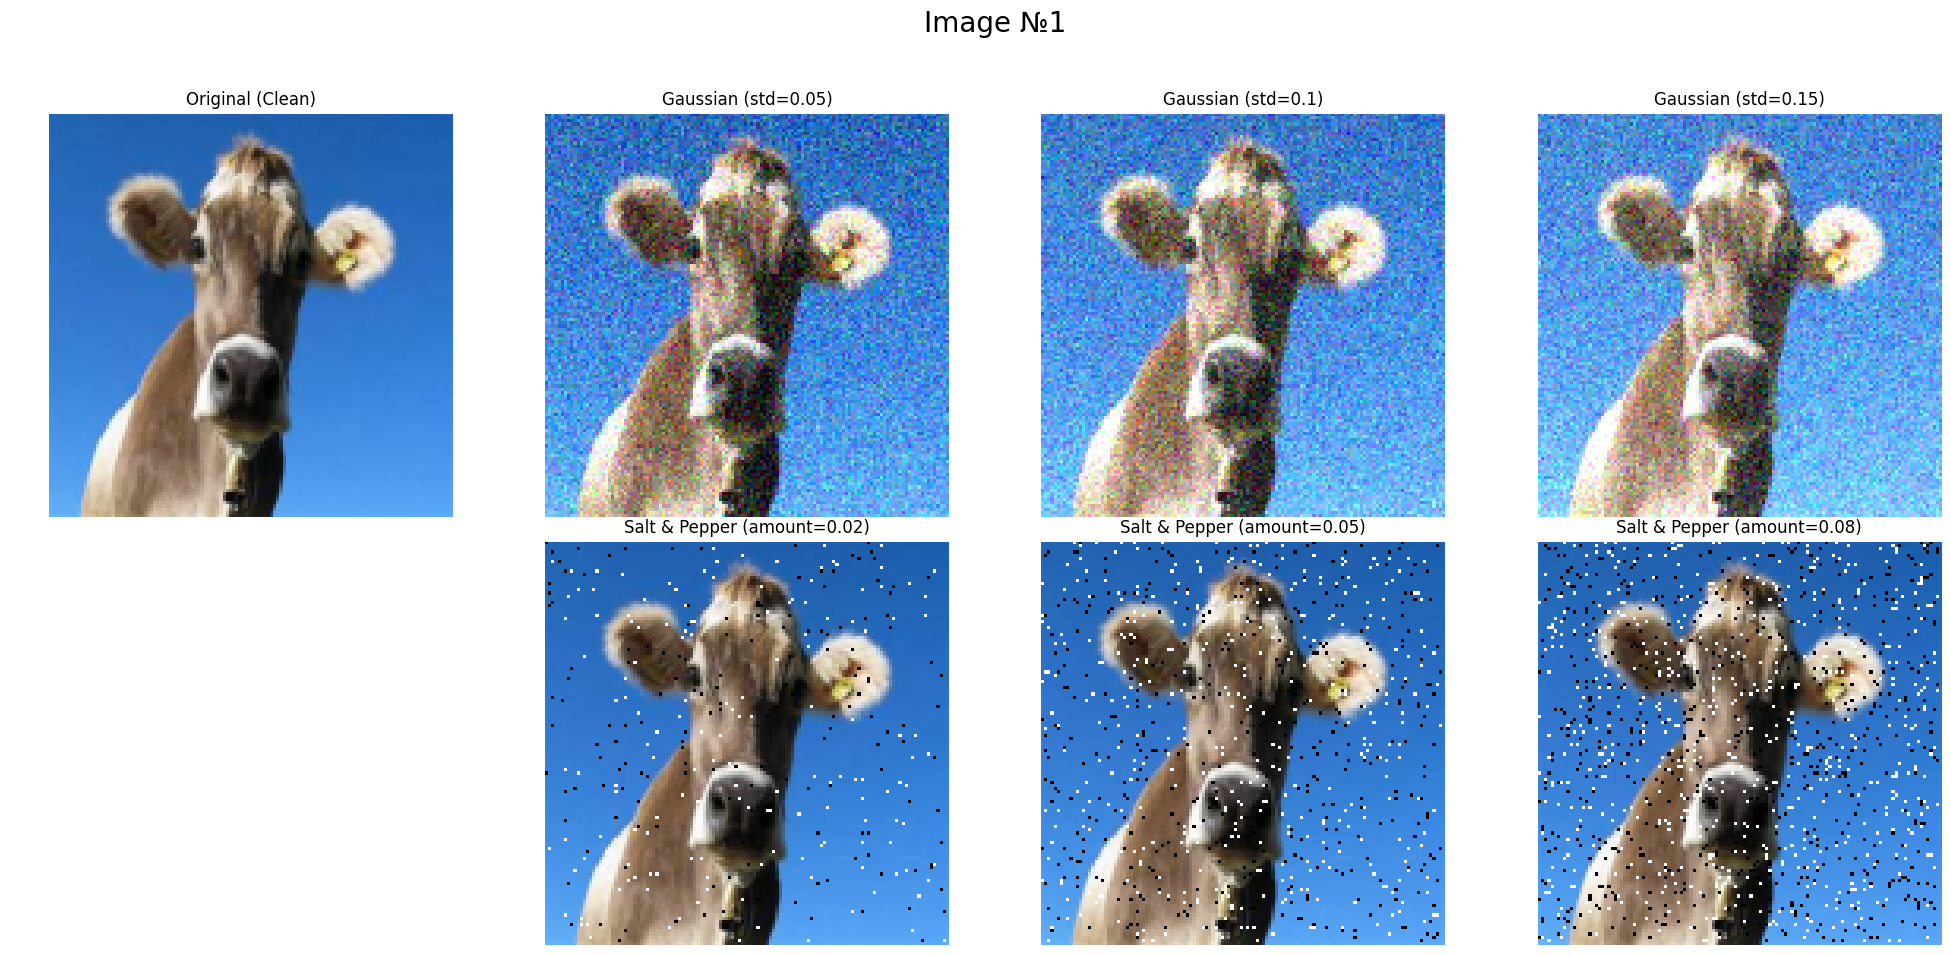

In [ ]:
simple_loader =  DataLoader(full_dataset, batch_size=4, shuffle=True)

visualize_noise_examples(simple_loader, num_images=1)

## Вспомогательные функции

In [ ]:
def get_train_val_test_loaders(dataset_name, transform, batch_size):
    full_dataset = torchvision.datasets.ImageFolder(root=dataset_name, transform=transform)

    train_val_size = int(0.8 * len(full_dataset))
    test_size = len(full_dataset) - train_val_size
    generator1 = torch.Generator().manual_seed(42)
    train_val_data, test_data = random_split(full_dataset, [train_val_size, test_size], generator=generator1)

    train_size = int(0.85 * len(train_val_data))
    val_size = len(train_val_data) - train_size
    generator2 = torch.Generator().manual_seed(42)
    train_data, val_data = random_split(train_val_data, [train_size, val_size], generator=generator2)

    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
    val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False, num_workers=2)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)

    return train_loader, val_loader, test_loader

In [ ]:
def restructure_results_for_plotting(result_dict):
    plot_data = {
        'gaussian': {},
        'salt_pepper': {}
    }

    for scenario_name, scenario_results in result_dict.items():
        noise_type, noise_level_str = scenario_name.rsplit('_', 1)
        noise_level = float(noise_level_str)

        for opt_name, opt_results in scenario_results.items():
            if opt_name not in plot_data[noise_type]:
                plot_data[noise_type][opt_name] = []

            test_accuracy = opt_results.get('test_accuracy')
            plot_data[noise_type][opt_name].append((noise_level, test_accuracy))

    for noise_type in plot_data:
        for opt_name in plot_data[noise_type]:
            plot_data[noise_type][opt_name].sort(key=lambda x: x[0])

    return plot_data

## Визуализация

In [ ]:
def plot_noise_vs_accuracy(plot_data):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7), sharey=True)

    ax1.set_title("Gaussian Noise", fontsize=16)
    ax1.set_xlabel("Noise level (std)", fontsize=12)
    ax1.set_ylabel("Test Accuracy (%)", fontsize=12)

    gaussian_data = plot_data.get('gaussian', {})

    for optimizer, data_points in gaussian_data.items():
        if not data_points:
            continue

        noise_levels = [point[0] for point in data_points]
        accuracies = [point[1] for point in data_points]

        ax1.plot(noise_levels, accuracies, label=optimizer, marker='o', linestyle='--')

    ax1.legend()
    ax1.grid(True)

    ax2.set_title("Salt & Pepper Noise", fontsize=16)
    ax2.set_xlabel("Noise level (amount)", fontsize=12)
    ax2.set_ylabel("Test Accuracy (%)", fontsize=12)

    sp_data = plot_data.get('salt_pepper', {})

    for optimizer, data_points in sp_data.items():
        if not data_points:
            continue

        noise_levels = [point[0] for point in data_points]
        accuracies = [point[1] for point in data_points]

        ax2.plot(noise_levels, accuracies, label=optimizer, marker='o', linestyle='--')

    ax2.legend()
    ax2.grid(True)

    plt.suptitle("Test Accuracy vs Noise Level", fontsize=20)
    plt.show()

In [ ]:
def plot_results_with_noise(results_dict):
    for scenario_name, scenario_results in results_dict.items():
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
        fig.suptitle(f"Optimizers with: {scenario_name}", fontsize=20)

        ax1.set_title("Val accuracy", fontsize=16)
        ax1.set_xlabel("Epoch", fontsize=12)
        ax1.set_ylabel("Accuracy (%)", fontsize=12)

        for opt_name, opt_results in scenario_results.items():
            accuracy_history = opt_results.get('accuracy')
            if accuracy_history:
                ax1.plot(accuracy_history, label=opt_name, marker='o', linestyle='--')

        ax1.legend()
        ax1.grid(True)

        ax2.set_title("Train loss", fontsize=16)
        ax2.set_xlabel("Epoch", fontsize=12)
        ax2.set_ylabel("Loss", fontsize=12)

        for opt_name, opt_results in scenario_results.items():
            loss_history = opt_results.get('loss')
            if loss_history:
                ax2.plot(loss_history, label=opt_name, marker='o', linestyle='--')

        ax2.legend()
        ax2.grid(True)

        plt.show()

In [ ]:
def plot_noise_vs_conv_time(results_dict, epoch_number):
    plot_data = []
    for scenario_name, scenario_results in results_dict.items():
        noise_type, noise_level_str = scenario_name.rsplit('_', 1)
        noise_level = float(noise_level_str)
        for opt_name, opt_results in scenario_results.items():
            convergence_time = opt_results.get('convergence_time', -1)

            if convergence_time == -1:
                convergence_time = (epoch_number * 65)

            plot_data.append({
                'noise_type': noise_type,
                'noise_level': noise_level,
                'optimizer': opt_name,
                'convergence_time': convergence_time
            })

    df = pd.DataFrame(plot_data)

    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
    fig.suptitle('Convergence Time (sec) vs. Noise Level', fontsize=20)

    ax1 = axes[0]
    gaussian_df = df[df['noise_type'] == 'gaussian']
    for optimizer_name, group in gaussian_df.groupby('optimizer'):
        group = group.sort_values('noise_level')
        ax1.plot(group['noise_level'], group['convergence_time'], marker='o', linestyle='-', label=optimizer_name)

    ax1.set_title('Noise Type: Gaussian', fontsize=16)
    ax1.set_xlabel('Noise Level (std)', fontsize=12)
    ax1.set_ylabel('Time to Converge (sec)', fontsize=12)
    ax1.legend()
    ax1.grid(True)

    ax2 = axes[1]
    sp_df = df[df['noise_type'] == 'salt_pepper']
    for optimizer_name, group in sp_df.groupby('optimizer'):
        group = group.sort_values('noise_level')
        ax2.plot(group['noise_level'], group['convergence_time'], marker='o', linestyle='-', label=optimizer_name)

    ax2.set_title('Noise Type: Salt & Pepper', fontsize=16)
    ax2.set_xlabel('Noise Level (amount)', fontsize=12)
    ax2.legend()
    ax2.grid(True)

    plt.show()

## Эксперимент с шумом


In [ ]:
def run_experiments_with_noise(cnn_model, class_num, epoch_number, lr, batch_size, criterion, noise_scenarios_to_test, target_loss = 0.3):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Experiment starts on the device: {device}\n")

    all_results_noisy = {}

    optimizers_to_test = {"SGD": optim.SGD, "Adam": optim.Adam, "LAMB": optim_extra.Lamb}

    for scenario_name, noise_transforms in noise_scenarios_to_test.items():
        print(f"\n{'='*50}\n Experiments with: {scenario_name}\n{'='*50}")

        if scenario_name == "salt_pepper_0.0":
            all_results_noisy[scenario_name] = all_results_noisy["gaussian_0.0"]
            print("Results are the same as with gaussian_0.0")
            continue

        current_transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            *noise_transforms,
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

        train_noisy_loader, val_noisy_loader, _ = get_train_val_test_loaders('raw-img', current_transform, batch_size)

        results_for_scenario = {}

        for opt_name, optimizer_class in optimizers_to_test.items():
            print(f"\n Train with: {opt_name}")

            model = cnn_model(class_num).to(device)

            if opt_name == "SGD":
                optimizer = optimizer_class(model.parameters(), lr, momentum=0.9)
            else:
                optimizer = optimizer_class(model.parameters(), lr)

            history_loss, history_val_accuracy = [], []
            convergence_time = -1

            start_time = time.time()

            for epoch in range(epoch_number):
                epoch_loss = train_one_epoch(model, optimizer, criterion, train_noisy_loader, device)
                val_accuracy = evaluate_model(model, val_noisy_loader, device)

                history_loss.append(epoch_loss)
                history_val_accuracy.append(val_accuracy)

                if epoch_loss <= target_loss and convergence_time == -1:
                    convergence_time = time.time() - start_time
                    print(f"Сonvergence was achieved in {convergence_time:.2f} seconds at {epoch + 1} epoch")

            print(f"Train loss: {epoch_loss:.4f}, Val accuracy: {val_accuracy:.2f}%")

            results_for_scenario[opt_name] = {
                "accuracy": history_val_accuracy,
                "loss": history_loss,
                "model_state": model.state_dict(),
                "convergence_time": convergence_time}

        all_results_noisy[scenario_name] = results_for_scenario

    return all_results_noisy, device


In [ ]:
EPOCH_NUMBER = 12
LEARNING_RATE = 0.001
TARGET_LOSS = 0.4
BATCH_SIZE = 64

criterion = nn.CrossEntropyLoss()

noise_scenarios_to_test = {
    "gaussian_0.05": [GaussianNoiseAdder(mean=0., std=0.05)],
    "gaussian_0.1": [GaussianNoiseAdder(mean=0., std=0.1)],
    "gaussian_0.15": [GaussianNoiseAdder(mean=0., std=0.15)],
    "salt_pepper_0.02": [SaltAndPepperNoiseAdder(amount=0.02)],
    "salt_pepper_0.05": [SaltAndPepperNoiseAdder(amount=0.05)],
    "salt_pepper_0.08": [SaltAndPepperNoiseAdder(amount=0.08)]
}

noise_results, device = run_experiments_with_noise(SimpleCNN, class_num, EPOCH_NUMBER, LEARNING_RATE, BATCH_SIZE, criterion, noise_scenarios_to_test, TARGET_LOSS)

Experiment starts on the device: cuda:0


 Experiments with: gaussian_0.05

 Train with: SGD
Сonvergence was achieved in 416.00 seconds at 8 epoch
Train loss: 0.1243, Val accuracy: 68.24%

 Train with: Adam
Сonvergence was achieved in 516.38 seconds at 10 epoch
Train loss: 0.3038, Val accuracy: 66.45%

 Train with: LAMB
Сonvergence was achieved in 544.31 seconds at 10 epoch
Train loss: 0.2417, Val accuracy: 67.70%

 Experiments with: gaussian_0.1

 Train with: SGD
Сonvergence was achieved in 479.47 seconds at 9 epoch
Train loss: 0.1788, Val accuracy: 67.98%

 Train with: Adam
Train loss: 0.4584, Val accuracy: 66.23%

 Train with: LAMB
Сonvergence was achieved in 648.70 seconds at 12 epoch
Train loss: 0.3427, Val accuracy: 66.20%

 Experiments with: gaussian_0.15

 Train with: SGD
Сonvergence was achieved in 584.60 seconds at 11 epoch
Train loss: 0.2852, Val accuracy: 66.26%

 Train with: Adam
Train loss: 0.5015, Val accuracy: 65.40%

 Train with: LAMB
Train loss: 0.4599, Val accuracy: 

In [ ]:
for scenario_name, scenario_results in noise_results.items():
    for opt_name, opt_results in scenario_results.items():
        model = SimpleCNN(class_num).to(device)
        model.load_state_dict(opt_results["model_state"])

        test_accuracy = evaluate_model(model, test_loader, device)

        noise_results[scenario_name][opt_name]['test_accuracy'] = test_accuracy
        conv_time = noise_results[scenario_name][opt_name]['convergence_time']

        print(f"Optimizer {opt_name} with {scenario_name}: Test accuracy = {test_accuracy:.2f}%, Convergence time: {conv_time:.2f}")

Optimizer SGD with gaussian_0.05: Test accuracy = 63.98%, Convergence time: 416.00
Optimizer Adam with gaussian_0.05: Test accuracy = 59.76%, Convergence time: 516.38
Optimizer LAMB with gaussian_0.05: Test accuracy = 59.59%, Convergence time: 544.31
Optimizer SGD with gaussian_0.1: Test accuracy = 41.81%, Convergence time: 479.47
Optimizer Adam with gaussian_0.1: Test accuracy = 39.44%, Convergence time: -1.00
Optimizer LAMB with gaussian_0.1: Test accuracy = 31.88%, Convergence time: 648.70
Optimizer SGD with gaussian_0.15: Test accuracy = 26.05%, Convergence time: 584.60
Optimizer Adam with gaussian_0.15: Test accuracy = 26.91%, Convergence time: -1.00
Optimizer LAMB with gaussian_0.15: Test accuracy = 27.52%, Convergence time: -1.00
Optimizer SGD with salt_pepper_0.02: Test accuracy = 66.69%, Convergence time: 465.39
Optimizer Adam with salt_pepper_0.02: Test accuracy = 65.78%, Convergence time: 560.70
Optimizer LAMB with salt_pepper_0.02: Test accuracy = 65.66%, Convergence time: 

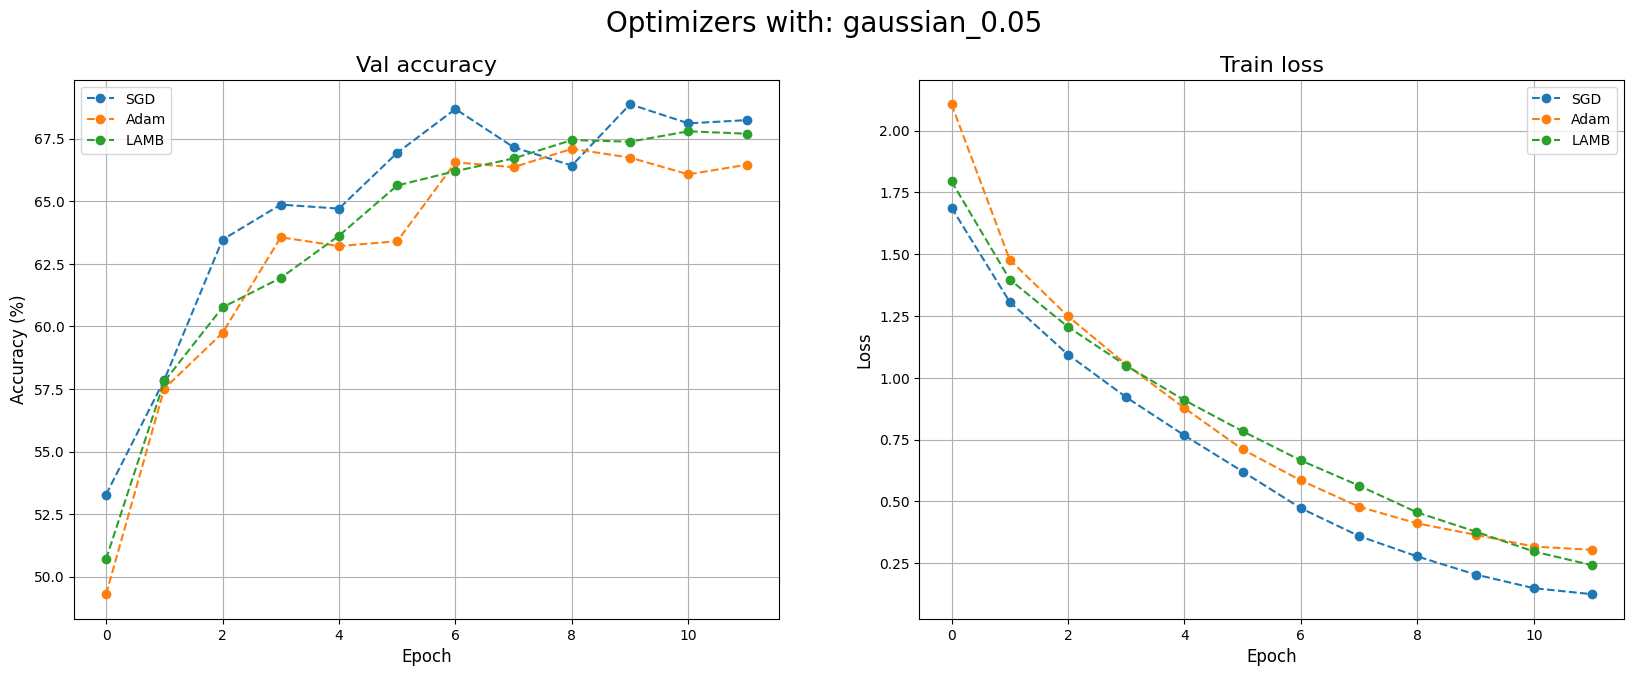

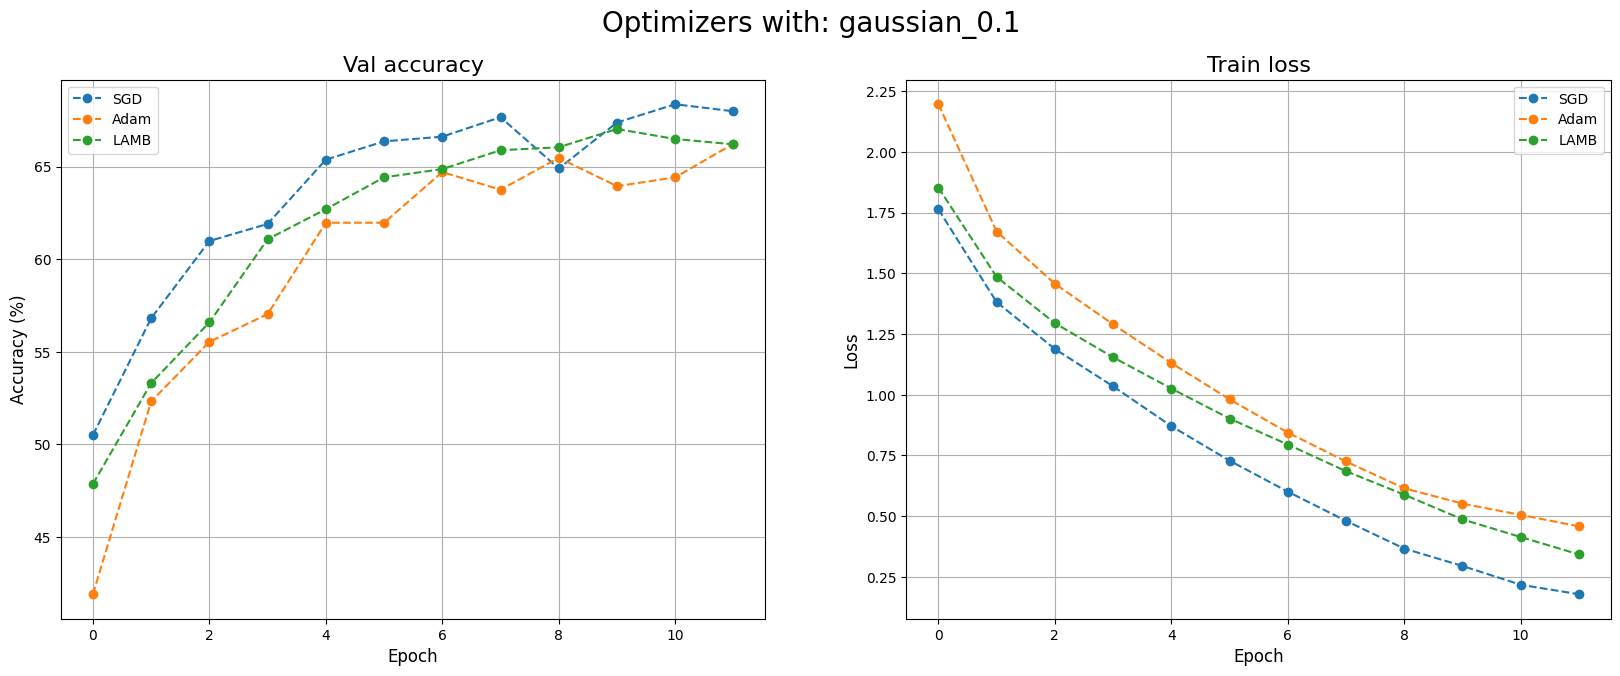

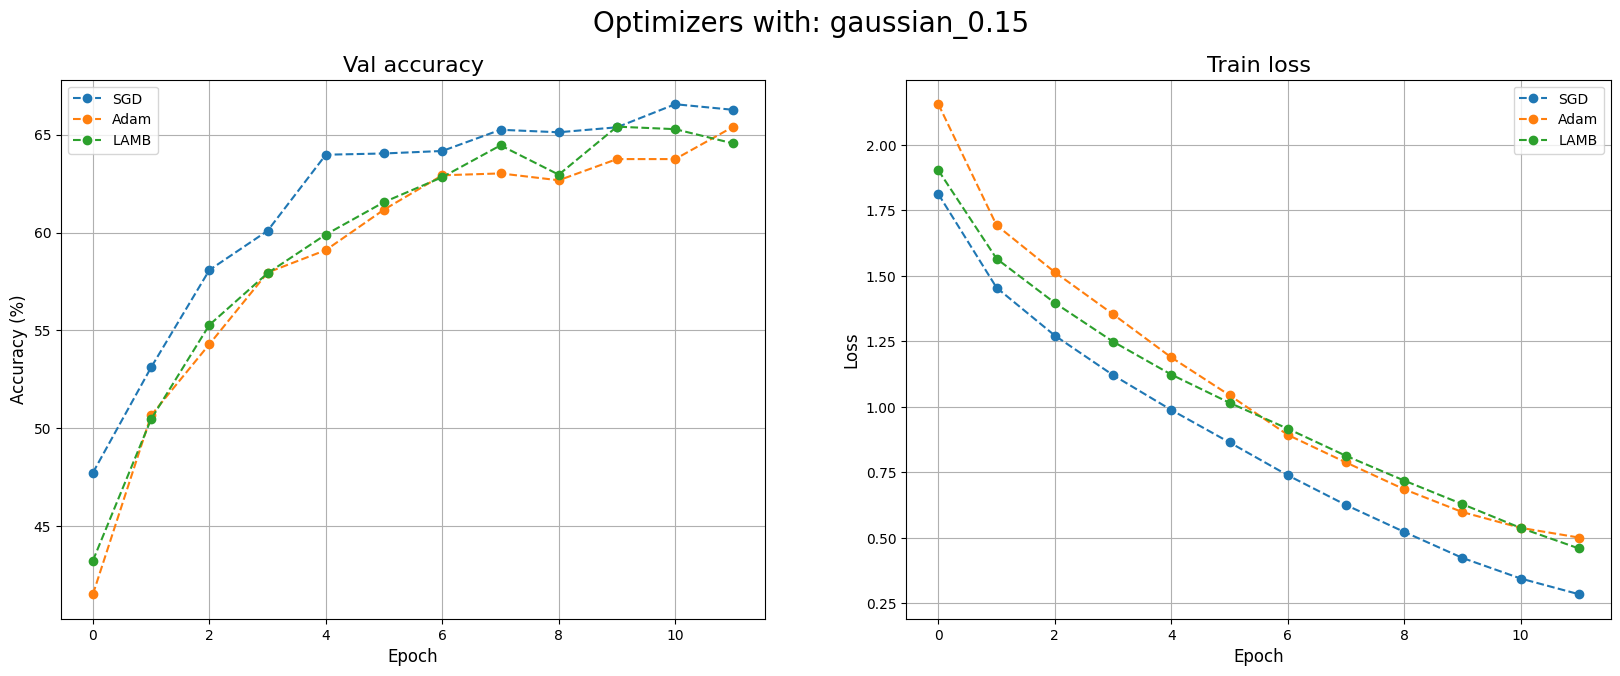

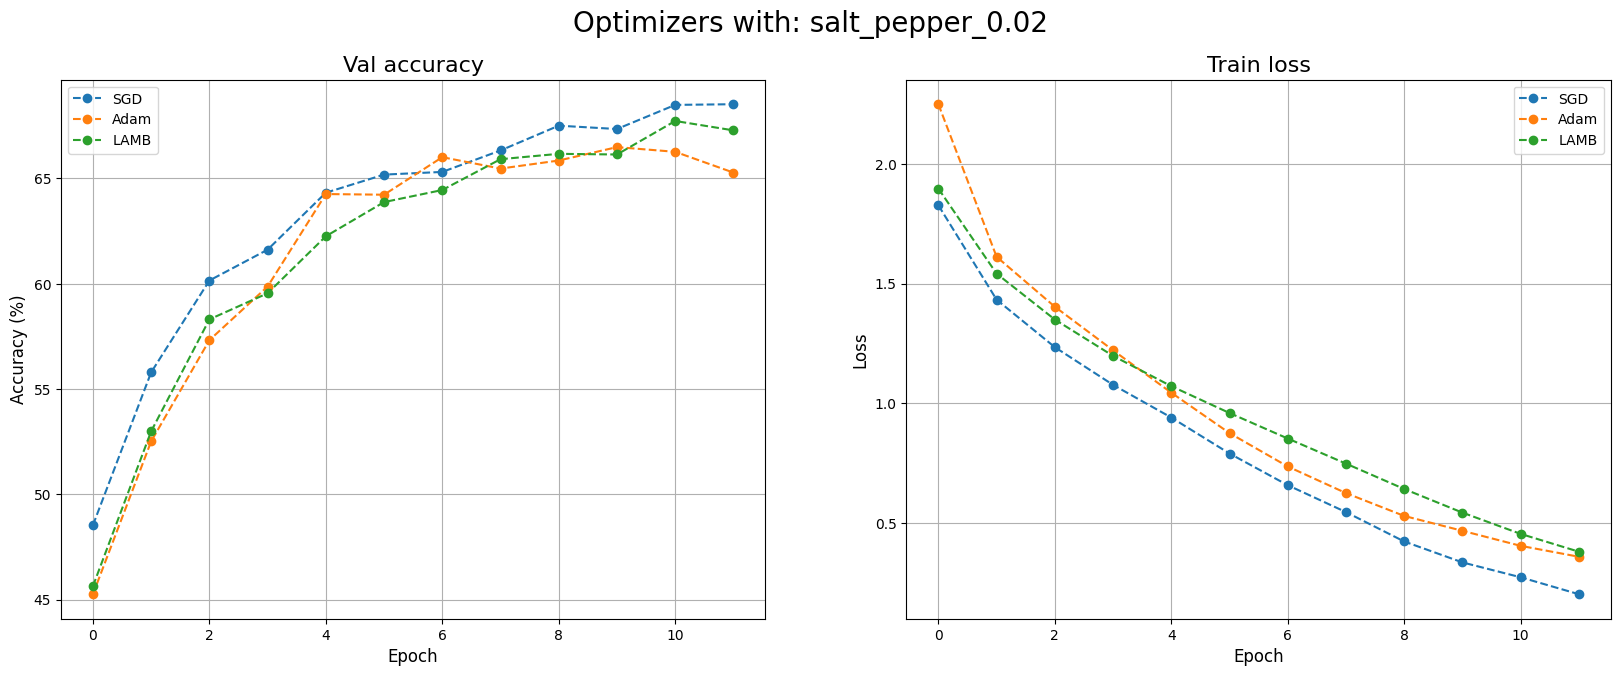

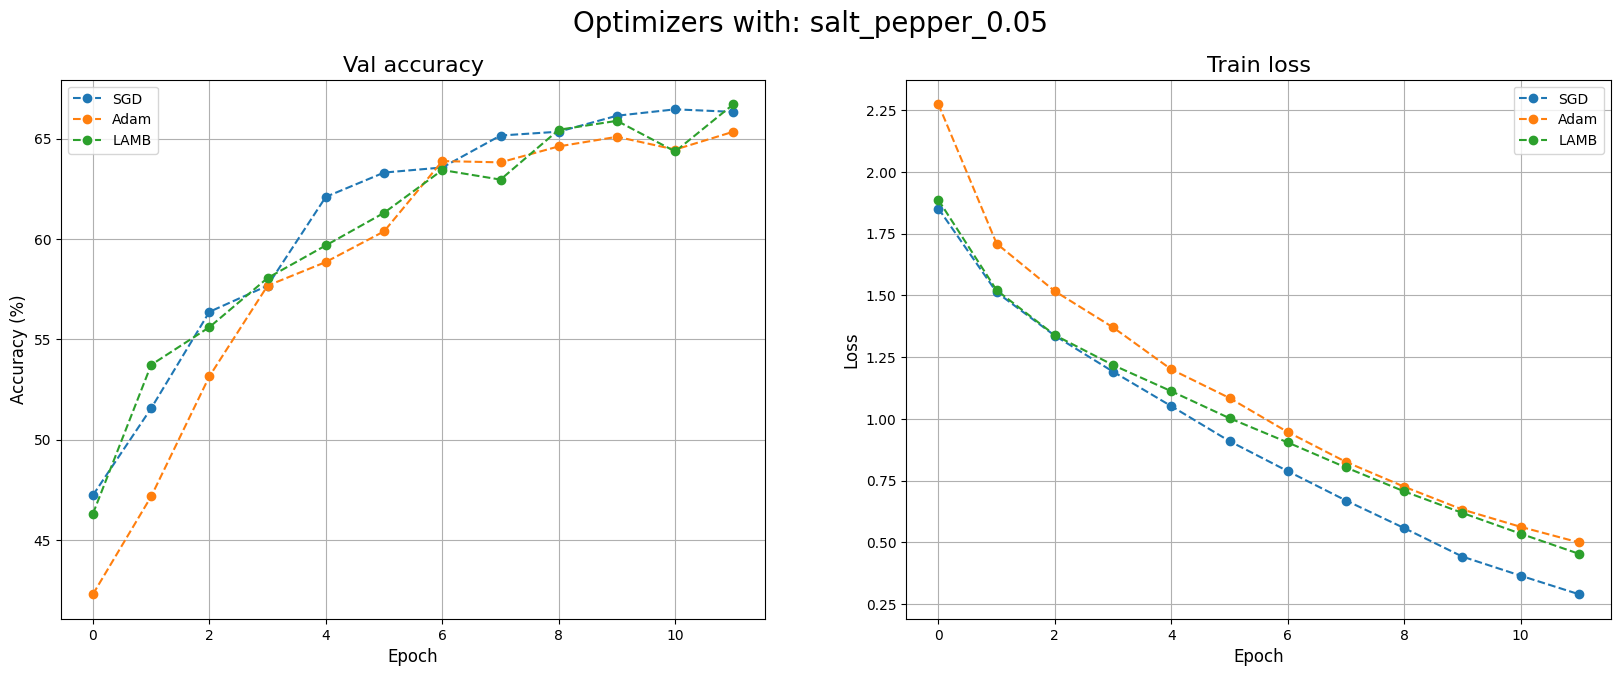

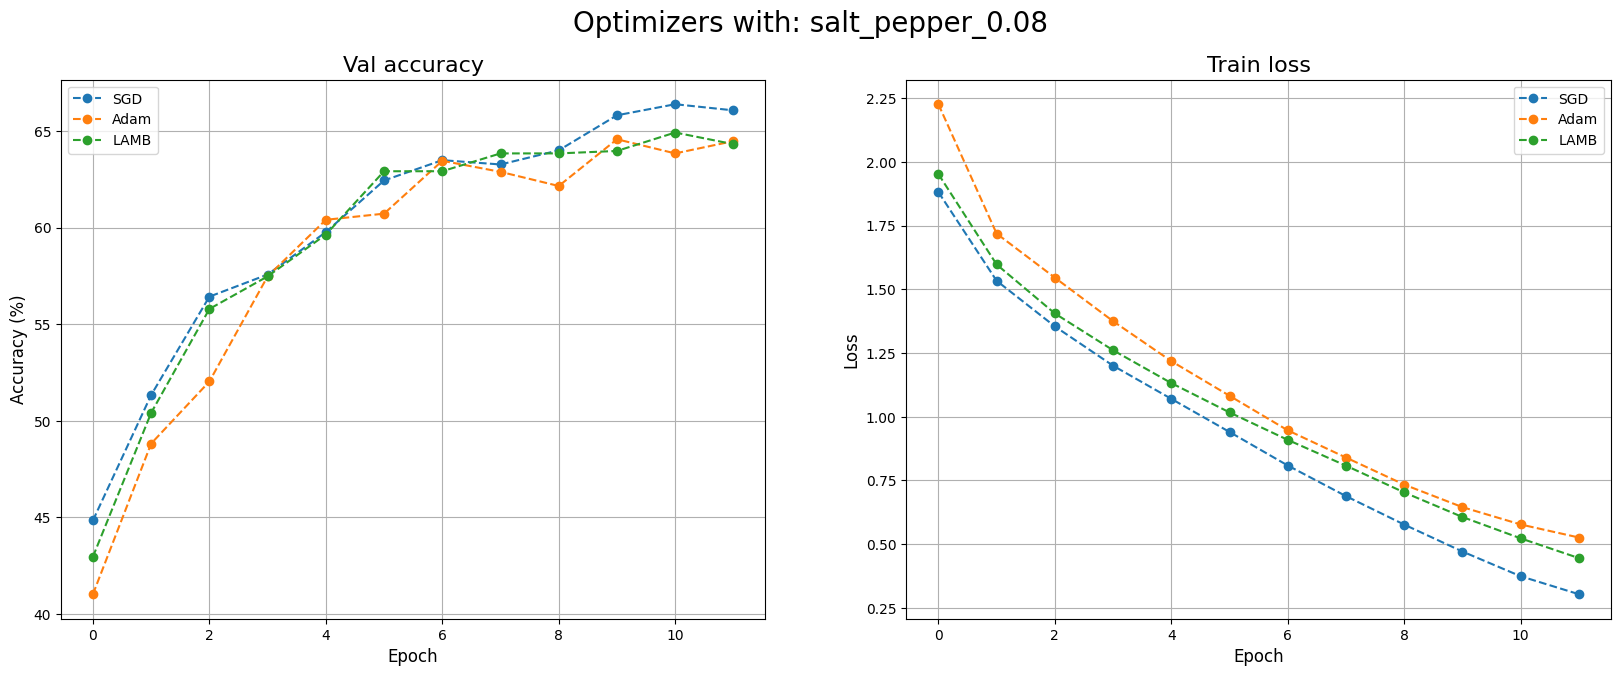

In [ ]:
plot_results_with_noise(noise_results)

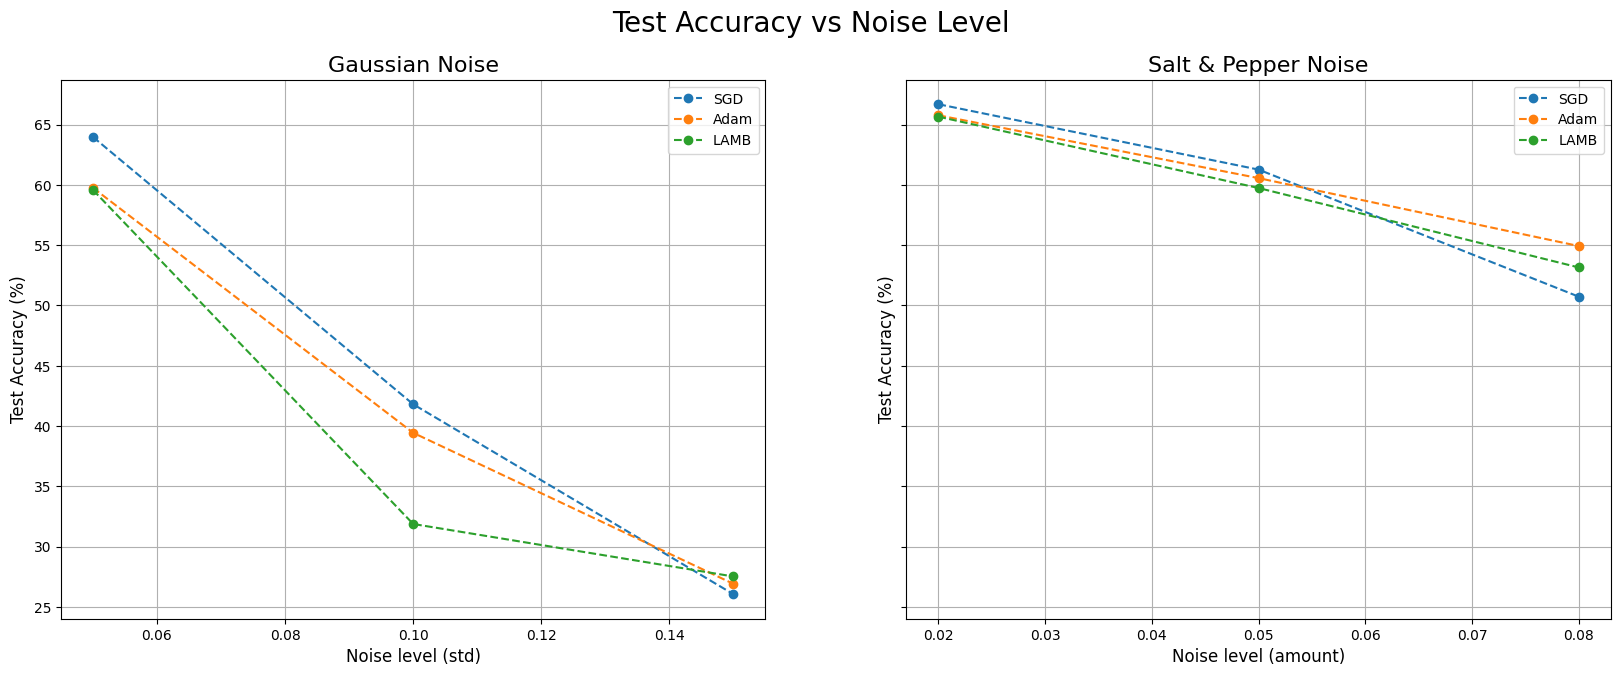

In [ ]:
plot_data = restructure_results_for_plotting(noise_results)

plot_noise_vs_accuracy(plot_data)

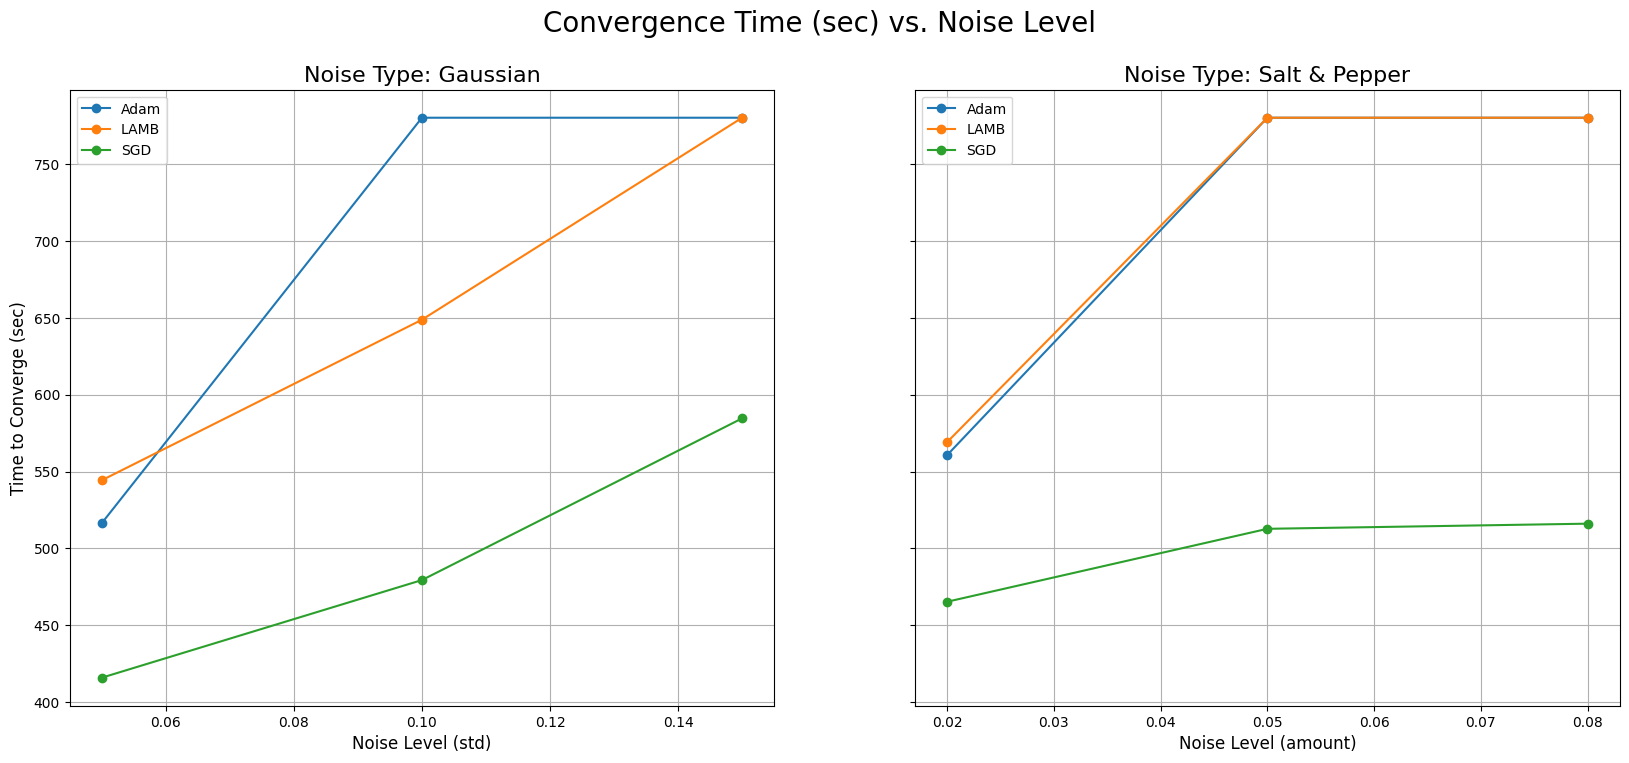

In [ ]:
plot_noise_vs_conv_time(noise_results, 12)

## Вторая версия

In [ ]:
EPOCH_NUMBER = 12
LEARNING_RATE = 0.001
TARGET_LOSS = 0.4
BATCH_SIZE = 64

criterion = nn.CrossEntropyLoss()

scenarios_to_test = {
    "gaussian_0.0": [GaussianNoiseAdder(mean=0., std=0.0)],
    "gaussian_0.05": [GaussianNoiseAdder(mean=0., std=0.05)],
    "gaussian_0.1": [GaussianNoiseAdder(mean=0., std=0.1)],
    "gaussian_0.15": [GaussianNoiseAdder(mean=0., std=0.15)],
    "salt_pepper_0.0": [SaltAndPepperNoiseAdder(amount=0.0)],
    "salt_pepper_0.02": [SaltAndPepperNoiseAdder(amount=0.02)],
    "salt_pepper_0.05": [SaltAndPepperNoiseAdder(amount=0.05)],
    "salt_pepper_0.08": [SaltAndPepperNoiseAdder(amount=0.08)]
}

all_results, device = run_experiments_with_noise(SimpleCNN, class_num, EPOCH_NUMBER, LEARNING_RATE, BATCH_SIZE, criterion, scenarios_to_test, TARGET_LOSS)

Experiment starts on the device: cuda:0


 Experiments with: gaussian_0.0

 Train with: SGD
Сonvergence was achieved in 396.92 seconds at 7 epoch
Train loss: 0.0686, Val accuracy: 68.59%

 Train with: Adam
Сonvergence was achieved in 488.88 seconds at 9 epoch
Train loss: 0.2581, Val accuracy: 67.85%

 Train with: LAMB
Сonvergence was achieved in 439.55 seconds at 8 epoch
Train loss: 0.1307, Val accuracy: 67.35%

 Experiments with: gaussian_0.05

 Train with: SGD
Сonvergence was achieved in 440.09 seconds at 8 epoch
Train loss: 0.1237, Val accuracy: 68.62%

 Train with: Adam
Сonvergence was achieved in 493.20 seconds at 9 epoch
Train loss: 0.2867, Val accuracy: 66.42%

 Train with: LAMB
Сonvergence was achieved in 610.14 seconds at 11 epoch
Train loss: 0.2584, Val accuracy: 66.96%

 Experiments with: gaussian_0.1

 Train with: SGD
Сonvergence was achieved in 491.58 seconds at 9 epoch
Train loss: 0.1818, Val accuracy: 67.25%

 Train with: Adam
Сonvergence was achieved in 652.72 seconds a

In [ ]:
print("Test results: ")

for scenario_name, scenario_results in all_results.items():
    for opt_name, opt_results in scenario_results.items():
        model = SimpleCNN(class_num).to(device)
        model.load_state_dict(opt_results["model_state"])

        metrics = evaluate_model_detailed(model, test_loader, device)

        conv_time = all_results[scenario_name][opt_name]['convergence_time']
        all_results[scenario_name][opt_name]['test_accuracy'] = test_accuracy

        if conv_time == -1:
           conv_time = 'Not achieved'
        else:
            conv_time = f"{conv_time:.2f} sec"

        print(f"{opt_name} with {scenario_name}: Accuracy = {metrics['accuracy']:.2f}%, Precision = {metrics['precision']:.2f}%, Recall = {metrics['recall']:.2f}%, F1 = {metrics['f1_score']:.2f}%, Convergence time: {conv_time}")

Test results: 
SGD with gaussian_0.0: Accuracy = 68.41%, Precision = 66.36%, Recall = 65.37%, F1 = 65.77%, Convergence time: 396.92 sec
Adam with gaussian_0.0: Accuracy = 67.59%, Precision = 66.21%, Recall = 63.40%, F1 = 64.46%, Convergence time: 488.88 sec
LAMB with gaussian_0.0: Accuracy = 66.73%, Precision = 64.88%, Recall = 63.62%, F1 = 64.00%, Convergence time: 439.55 sec
SGD with gaussian_0.05: Accuracy = 61.17%, Precision = 65.76%, Recall = 55.43%, F1 = 57.36%, Convergence time: 440.09 sec
Adam with gaussian_0.05: Accuracy = 61.61%, Precision = 65.74%, Recall = 55.86%, F1 = 57.96%, Convergence time: 493.20 sec
LAMB with gaussian_0.05: Accuracy = 58.00%, Precision = 64.43%, Recall = 51.98%, F1 = 54.49%, Convergence time: 610.14 sec
SGD with gaussian_0.1: Accuracy = 51.28%, Precision = 61.30%, Recall = 43.47%, F1 = 44.14%, Convergence time: 491.58 sec
Adam with gaussian_0.1: Accuracy = 47.73%, Precision = 61.16%, Recall = 37.78%, F1 = 39.02%, Convergence time: 652.72 sec
LAMB with

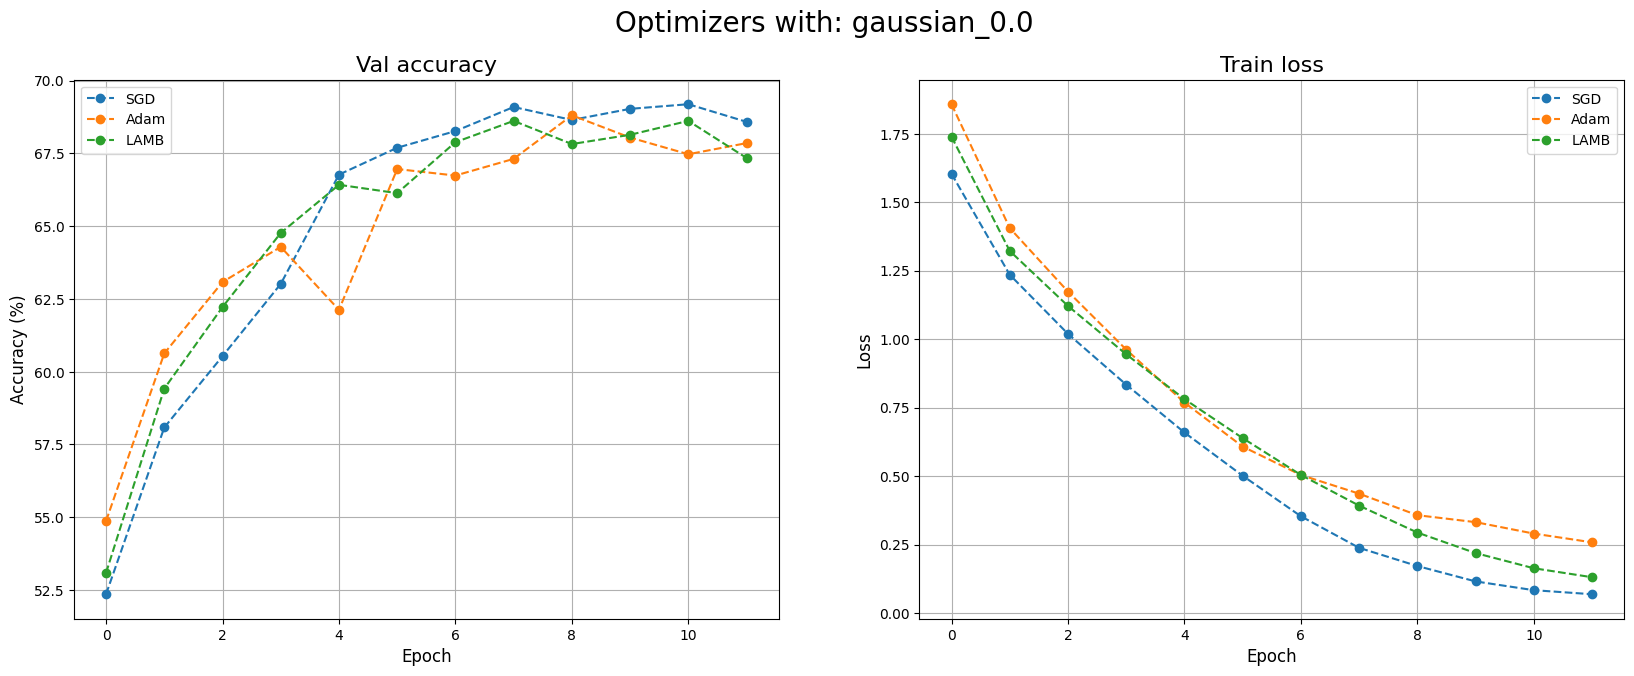

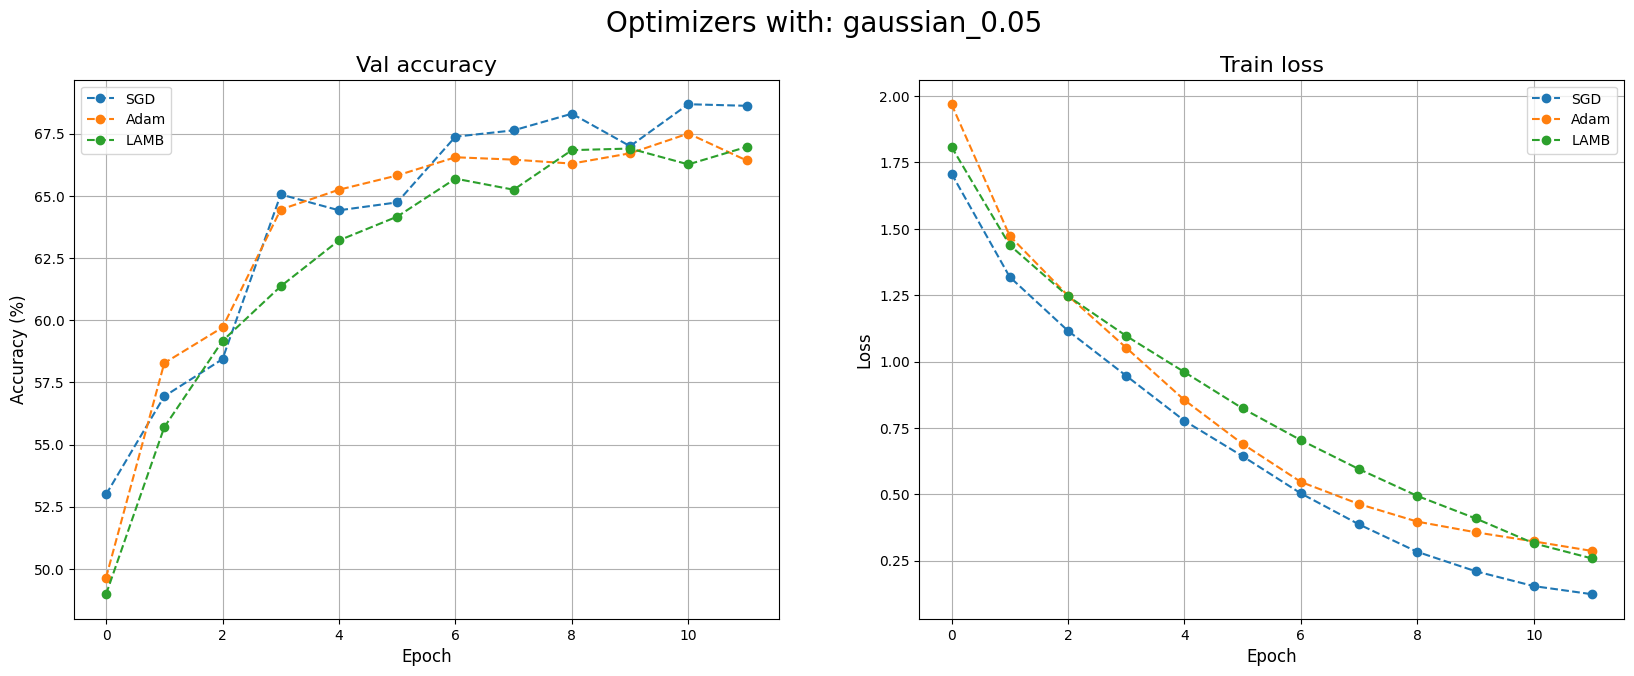

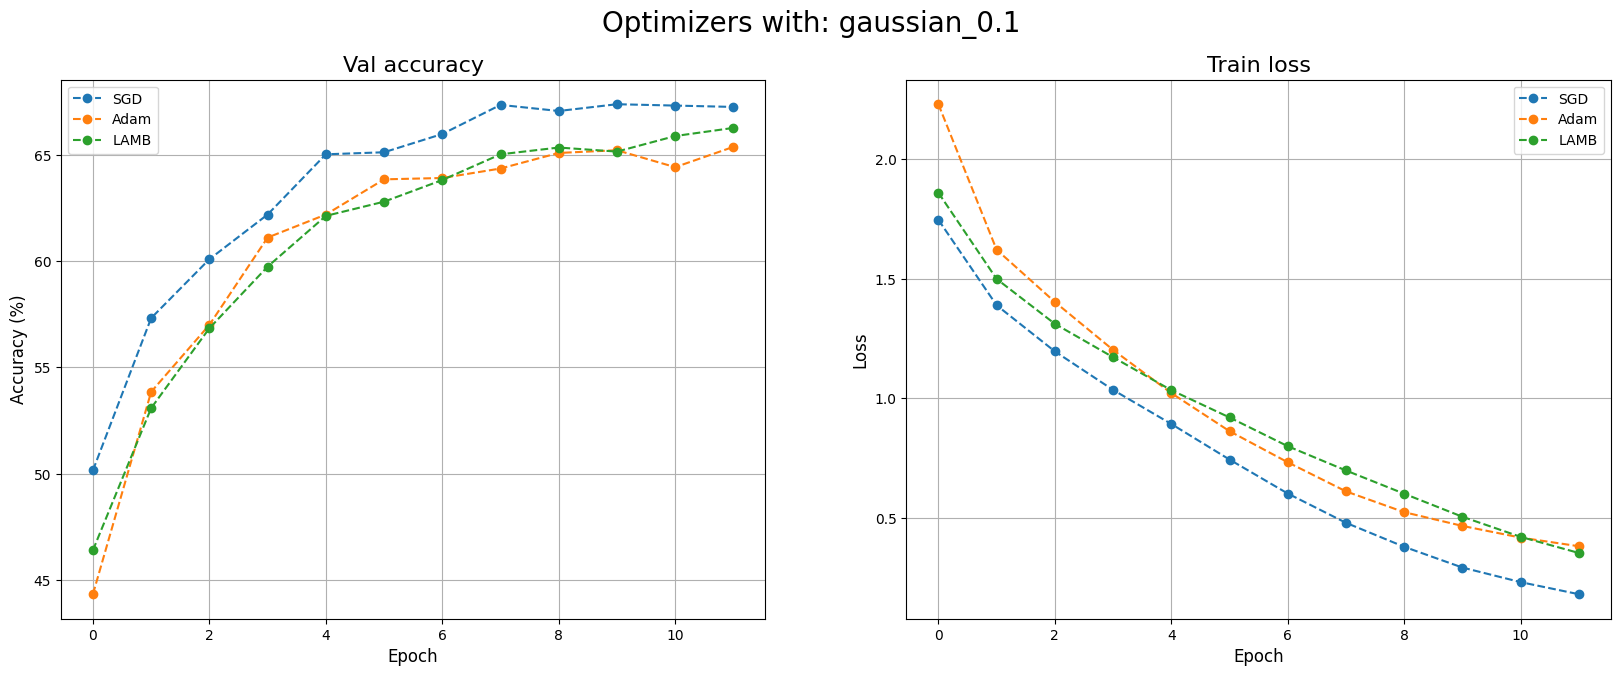

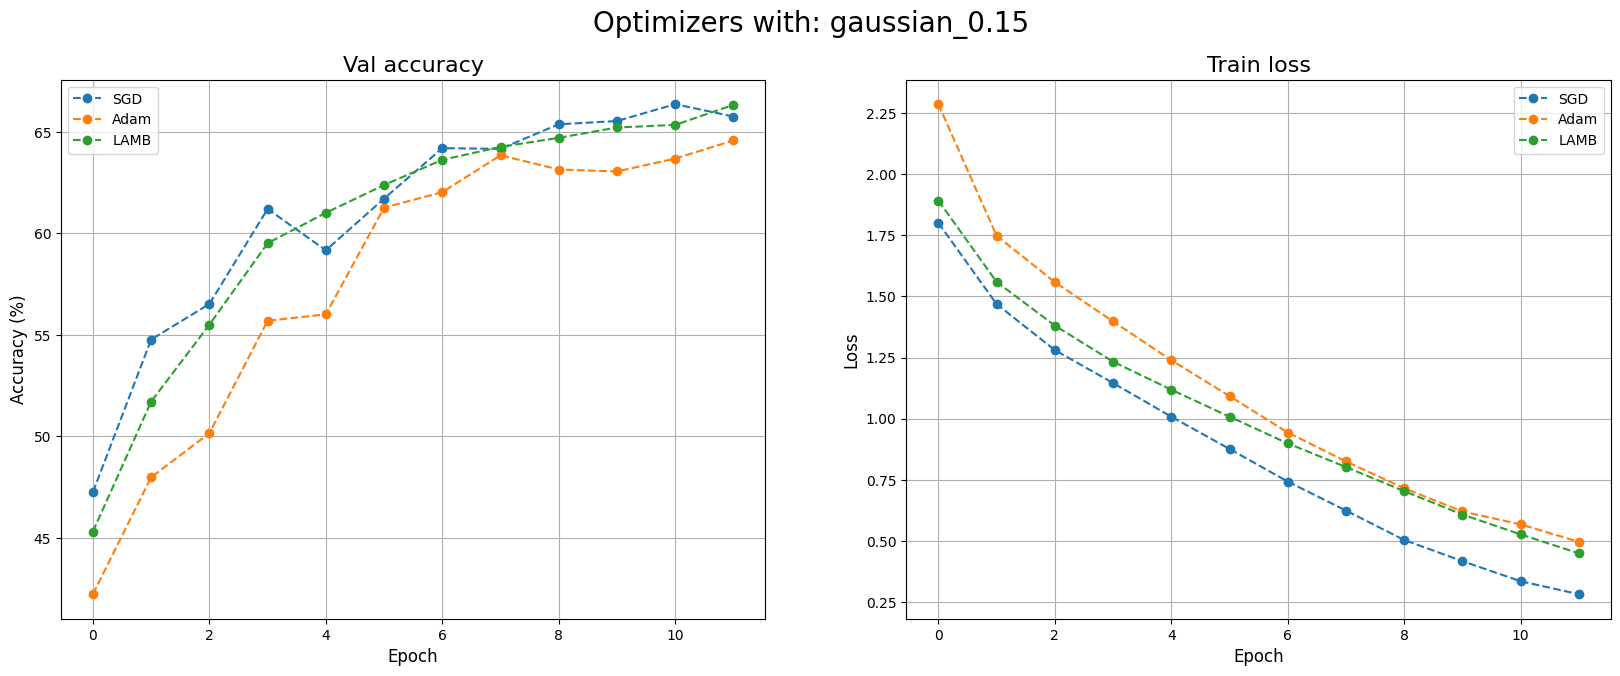

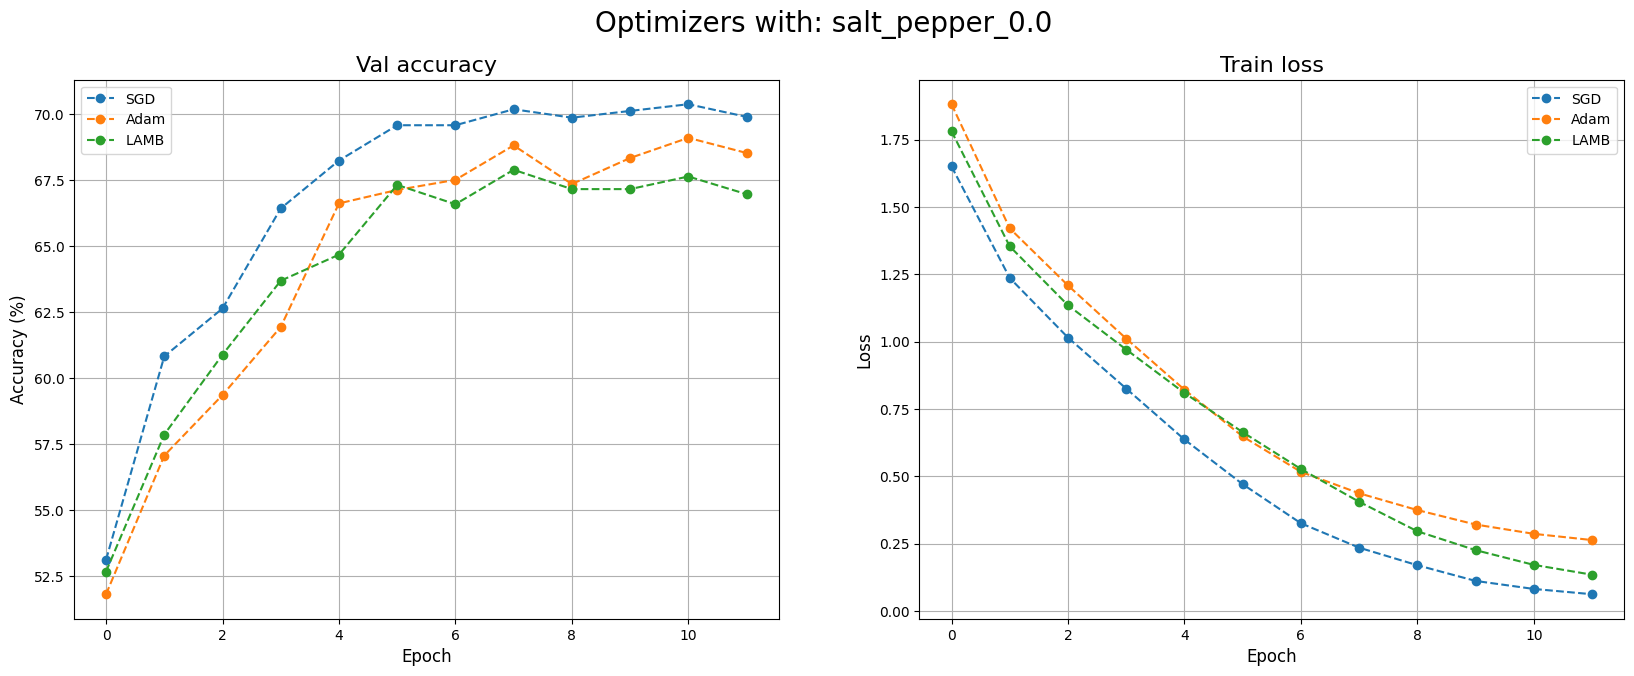

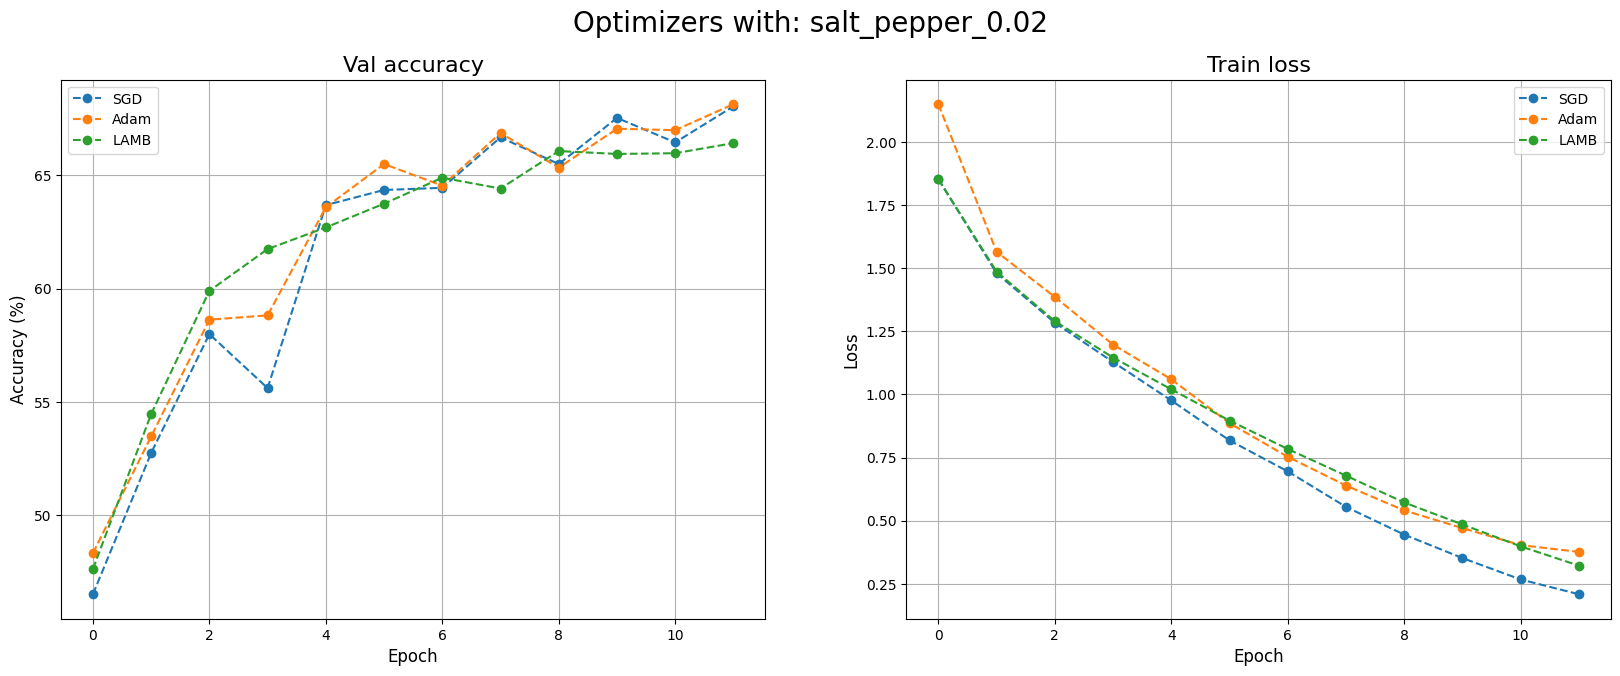

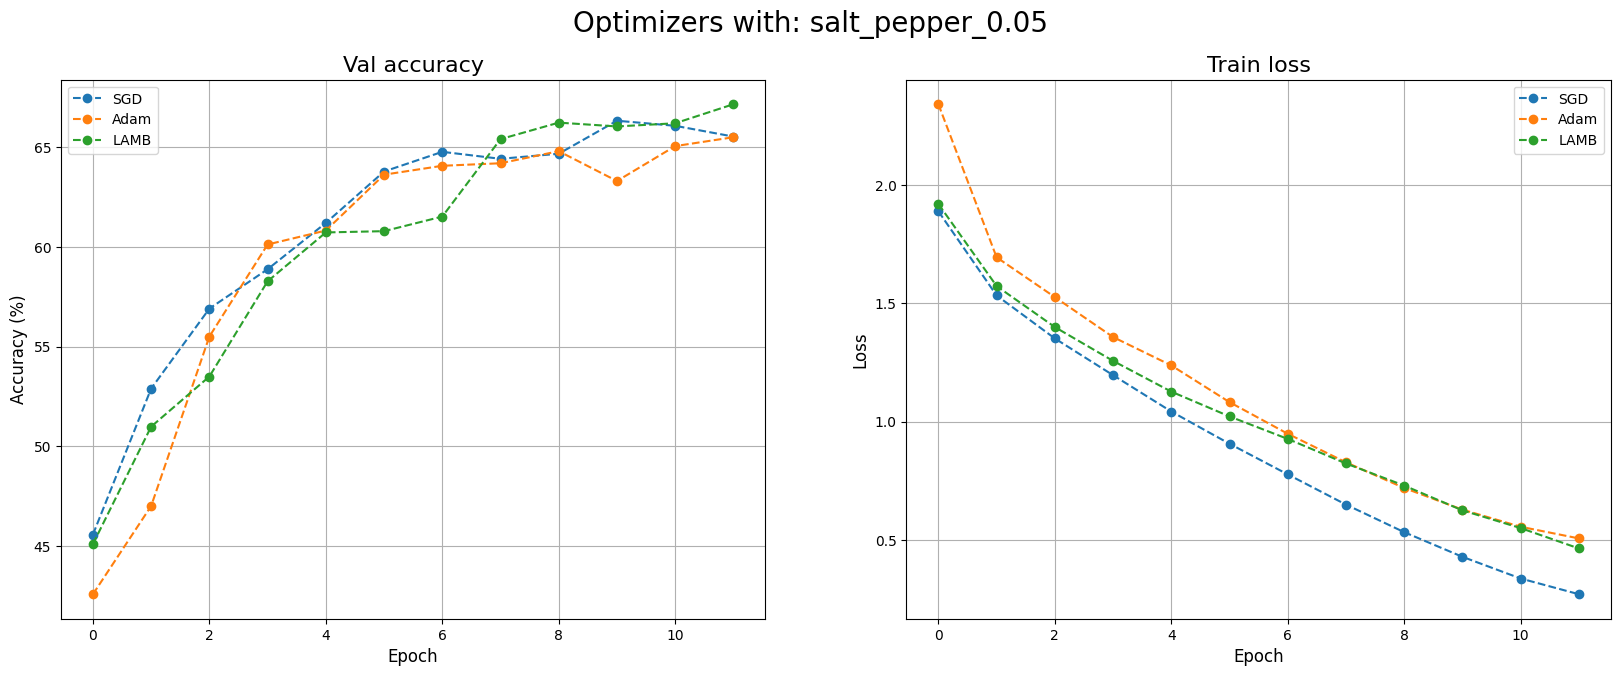

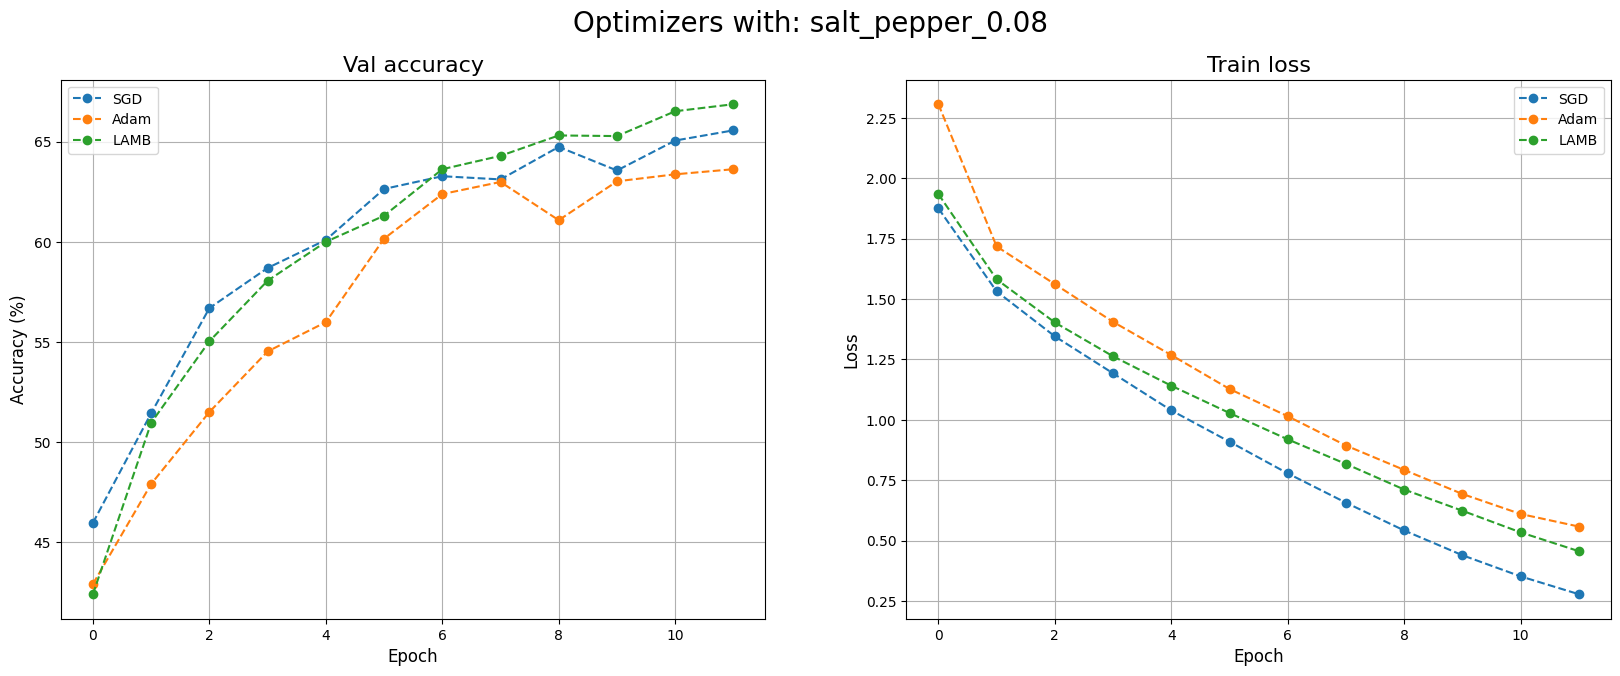

In [ ]:
plot_results_with_noise(all_results)

In [ ]:
all_accuracy = {
    'gaussian_0.0': {
        'SGD': {'test_accuracy': 68.41},
        'Adam': {'test_accuracy': 67.59},
        'LAMB': {'test_accuracy': 66.73}
    },
    'gaussian_0.05': {
        'SGD': {'test_accuracy': 61.17},
        'Adam': {'test_accuracy': 61.61},
        'LAMB': {'test_accuracy': 58.00}
    },
    'gaussian_0.1': {
        'SGD': {'test_accuracy': 51.28},
        'Adam': {'test_accuracy': 47.73},
        'LAMB': {'test_accuracy': 41.75}
    },
    'gaussian_0.15': {
        'SGD': {'test_accuracy': 32.60},
        'Adam': {'test_accuracy': 39.72},
        'LAMB': {'test_accuracy': 24.14}
    },
    'salt_pepper_0.0': {
        'SGD': {'test_accuracy': 68.70},
        'Adam': {'test_accuracy': 68.26},
        'LAMB': {'test_accuracy': 66.63}
    },
    'salt_pepper_0.02': {
        'SGD': {'test_accuracy': 66.31},
        'Adam': {'test_accuracy': 66.62},
        'LAMB': {'test_accuracy': 62.83}
    },
    'salt_pepper_0.05': {
        'SGD': {'test_accuracy': 57.30},
        'Adam': {'test_accuracy': 65.07},
        'LAMB': {'test_accuracy': 59.91}
    },
    'salt_pepper_0.08': {
        'SGD': {'test_accuracy': 60.41},
        'Adam': {'test_accuracy': 51.60},
        'LAMB': {'test_accuracy': 55.73}
    }
}

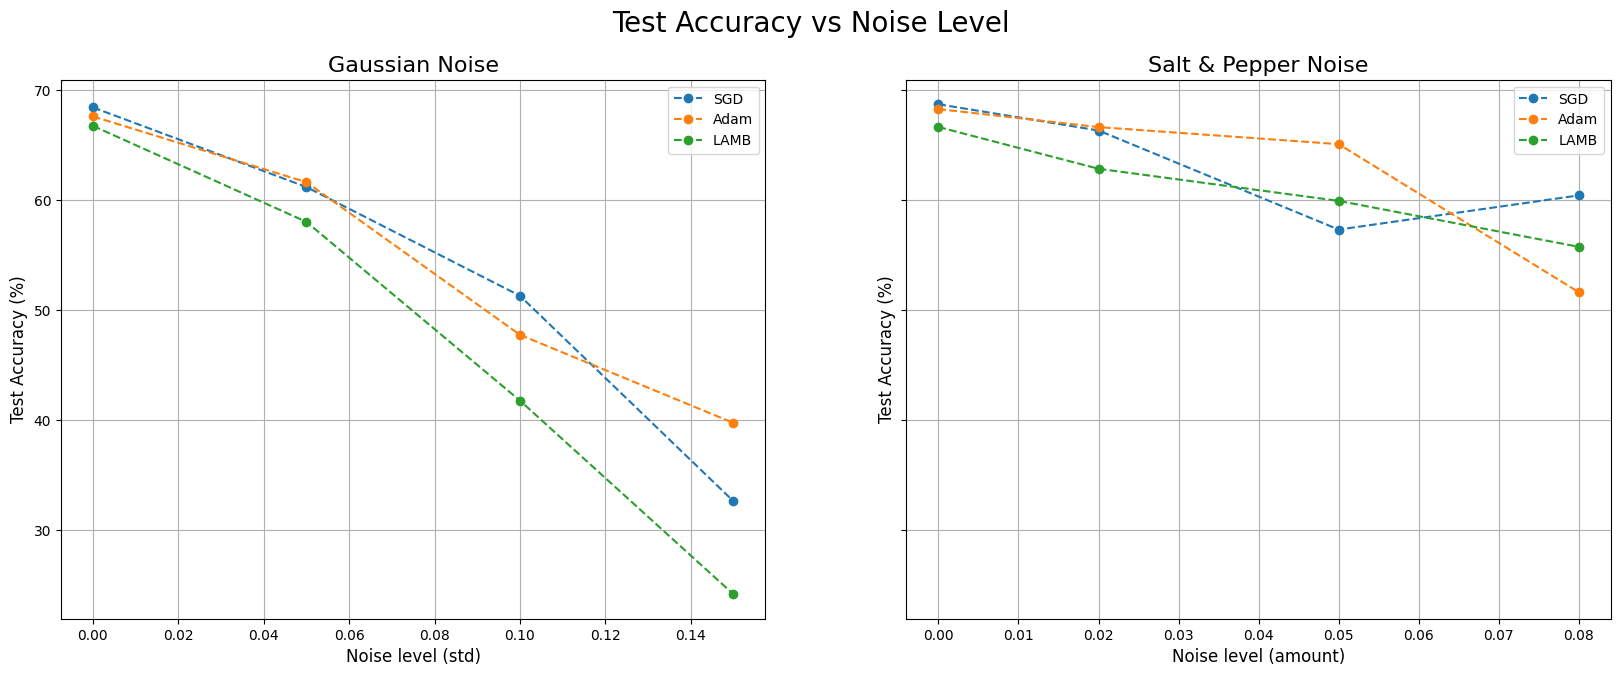

In [ ]:
plot_data = restructure_results_for_plotting(all_accuracy)

plot_noise_vs_accuracy(plot_data)

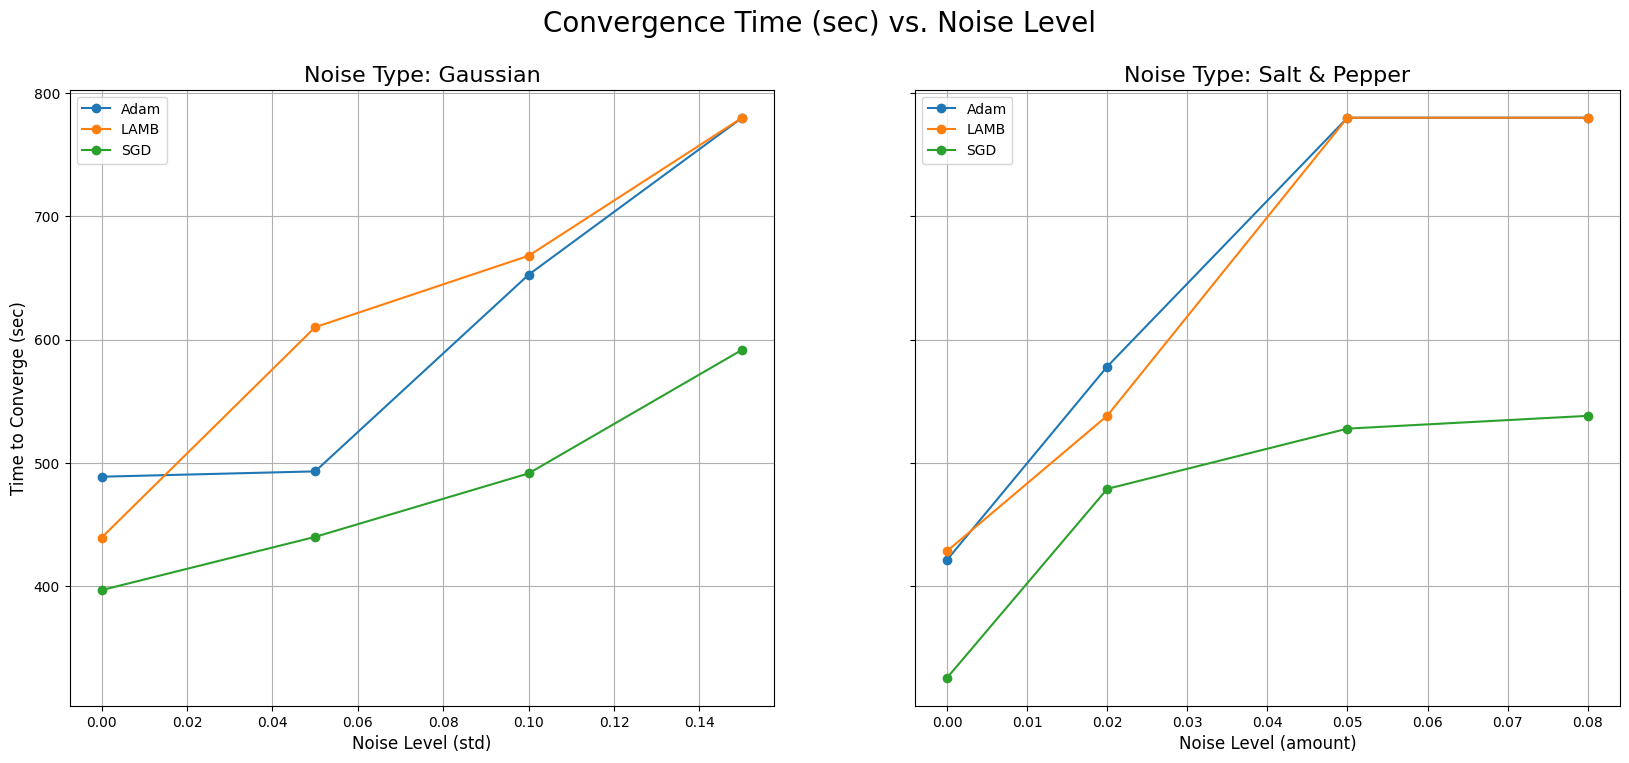

In [ ]:
plot_noise_vs_conv_time(all_results, 12)

## Третья версия

In [ ]:
EPOCH_NUMBER = 12
LEARNING_RATE = 0.001
TARGET_LOSS = 0.4
BATCH_SIZE = 64

criterion = nn.CrossEntropyLoss()

scenarios_to_test = {
    "gaussian_0.0": [GaussianNoiseAdder(mean=0., std=0.0)],
    "gaussian_0.05": [GaussianNoiseAdder(mean=0., std=0.05)],
    "gaussian_0.1": [GaussianNoiseAdder(mean=0., std=0.1)],
    "gaussian_0.15": [GaussianNoiseAdder(mean=0., std=0.15)],
    "salt_pepper_0.0": [SaltAndPepperNoiseAdder(amount=0.0)],
    "salt_pepper_0.02": [SaltAndPepperNoiseAdder(amount=0.02)],
    "salt_pepper_0.05": [SaltAndPepperNoiseAdder(amount=0.05)],
    "salt_pepper_0.08": [SaltAndPepperNoiseAdder(amount=0.08)]
}

all_results, device = run_experiments_with_noise(SimpleCNN, class_num, EPOCH_NUMBER, LEARNING_RATE, BATCH_SIZE, criterion, scenarios_to_test, TARGET_LOSS)

Experiment starts on the device: cuda:0


 Experiments with: gaussian_0.0

 Train with: SGD
Сonvergence was achieved in 367.67 seconds at 7 epoch
Train loss: 0.0699, Val accuracy: 69.76%

 Train with: Adam
Сonvergence was achieved in 470.24 seconds at 9 epoch
Train loss: 0.2811, Val accuracy: 67.25%

 Train with: LAMB
Сonvergence was achieved in 418.28 seconds at 8 epoch
Train loss: 0.1229, Val accuracy: 66.55%

 Experiments with: gaussian_0.05

 Train with: SGD
Сonvergence was achieved in 407.25 seconds at 8 epoch
Train loss: 0.1059, Val accuracy: 66.49%

 Train with: Adam
Сonvergence was achieved in 501.76 seconds at 10 epoch
Train loss: 0.3219, Val accuracy: 66.07%

 Train with: LAMB
Сonvergence was achieved in 514.72 seconds at 10 epoch
Train loss: 0.2491, Val accuracy: 66.49%

 Experiments with: gaussian_0.1

 Train with: SGD
Сonvergence was achieved in 456.79 seconds at 9 epoch
Train loss: 0.1817, Val accuracy: 66.23%

 Train with: Adam
Train loss: 0.4032, Val accuracy: 64.48%

 

In [ ]:
print("Test results: \n")

for scenario_name, scenario_results in all_results.items():
    for opt_name, opt_results in scenario_results.items():
        model = SimpleCNN(class_num).to(device)
        model.load_state_dict(opt_results["model_state"])

        metrics = evaluate_model_detailed(model, test_loader, device)

        conv_time = all_results[scenario_name][opt_name]['convergence_time']
        all_results[scenario_name][opt_name]['test_accuracy'] = metrics['accuracy']

        if conv_time == -1:
           conv_time = 'Not achieved'
        else:
            conv_time = f"{conv_time:.2f} sec"

        print(f"{opt_name} with {scenario_name}: Accuracy = {metrics['accuracy']:.2f}%, Precision = {metrics['precision']:.2f}%, Recall = {metrics['recall']:.2f}%, F1 = {metrics['f1_score']:.2f}%, Convergence time: {conv_time}")

    print("\n")

Test results: 

SGD with gaussian_0.0: Accuracy = 69.23%, Precision = 67.40%, Recall = 66.05%, F1 = 66.49%, Convergence time: 367.67 sec
Adam with gaussian_0.0: Accuracy = 66.94%, Precision = 65.36%, Recall = 62.72%, F1 = 63.51%, Convergence time: 470.24 sec
LAMB with gaussian_0.0: Accuracy = 67.11%, Precision = 67.05%, Recall = 61.70%, F1 = 63.57%, Convergence time: 418.28 sec


SGD with gaussian_0.05: Accuracy = 60.52%, Precision = 63.67%, Recall = 56.18%, F1 = 58.00%, Convergence time: 407.25 sec
Adam with gaussian_0.05: Accuracy = 56.05%, Precision = 61.96%, Recall = 51.99%, F1 = 53.07%, Convergence time: 501.76 sec
LAMB with gaussian_0.05: Accuracy = 48.95%, Precision = 61.89%, Recall = 41.62%, F1 = 42.50%, Convergence time: 514.72 sec


SGD with gaussian_0.1: Accuracy = 37.49%, Precision = 60.78%, Recall = 32.26%, F1 = 32.49%, Convergence time: 456.79 sec
Adam with gaussian_0.1: Accuracy = 45.49%, Precision = 58.75%, Recall = 40.23%, F1 = 39.80%, Convergence time: Not achieved
LA

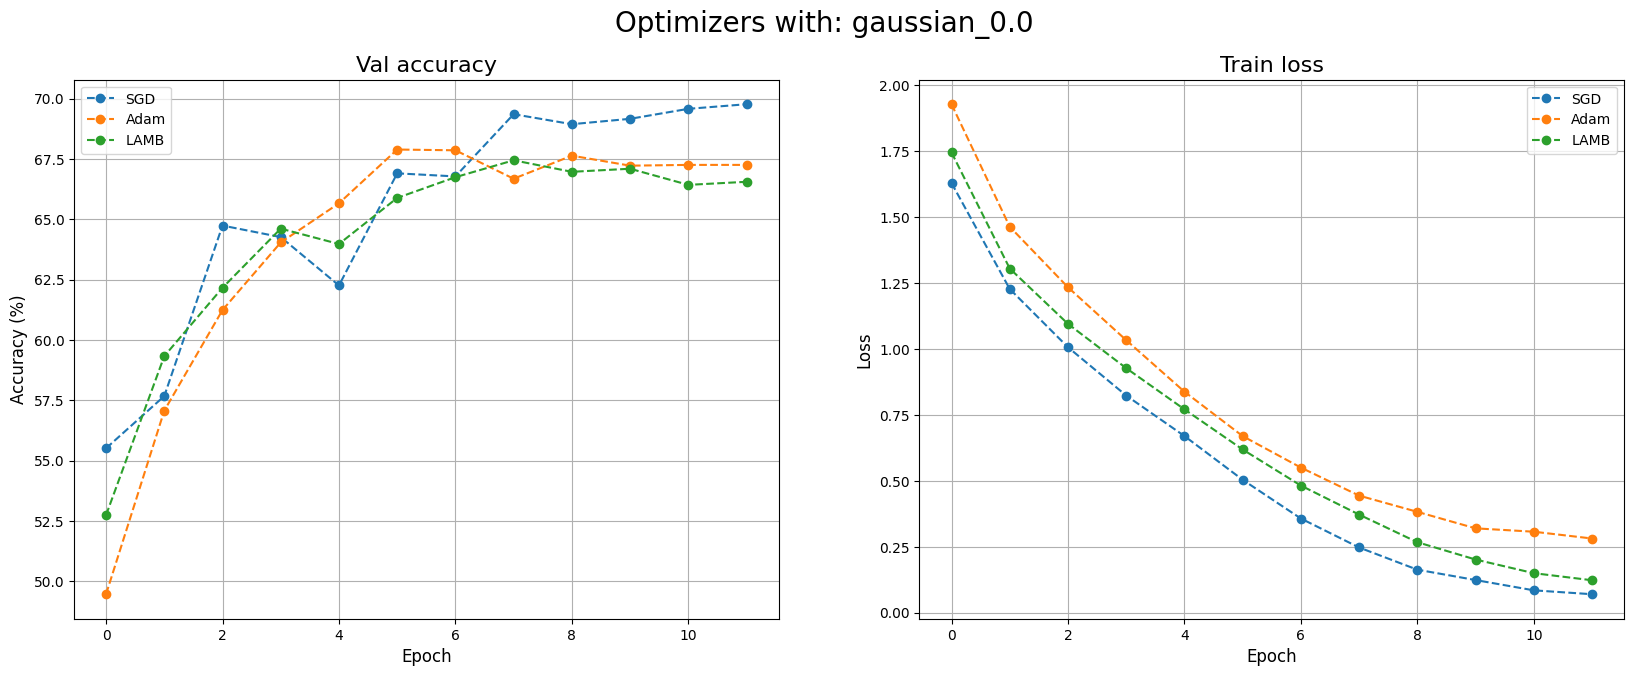

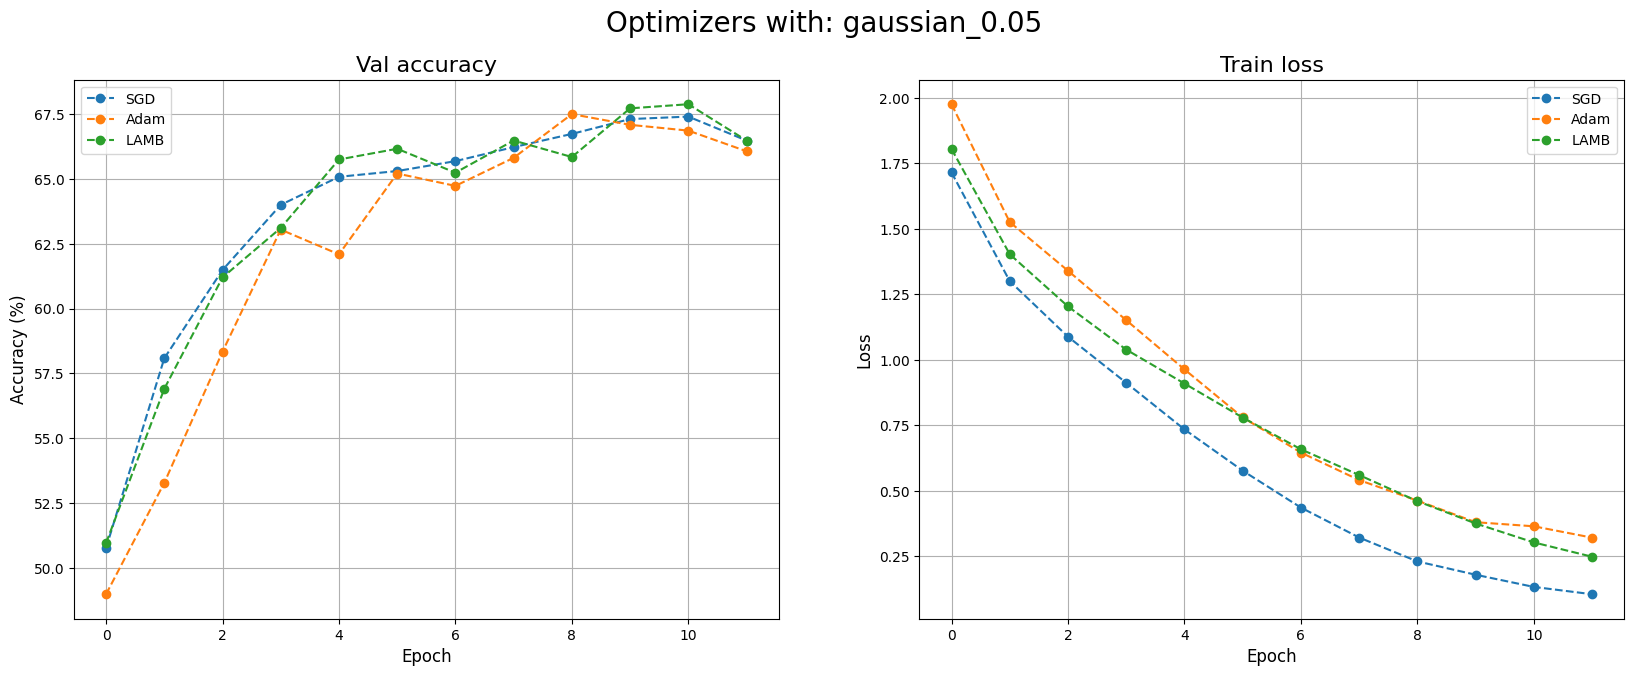

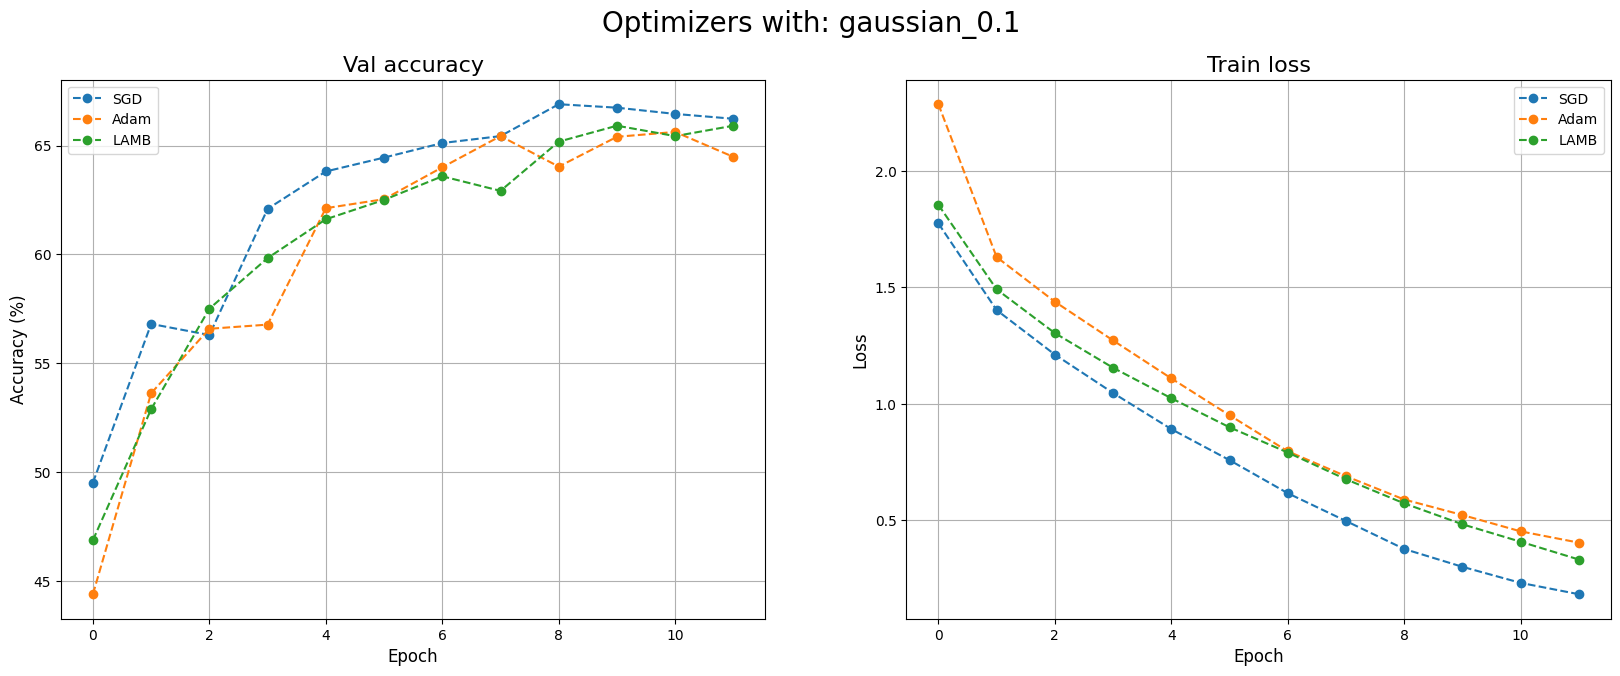

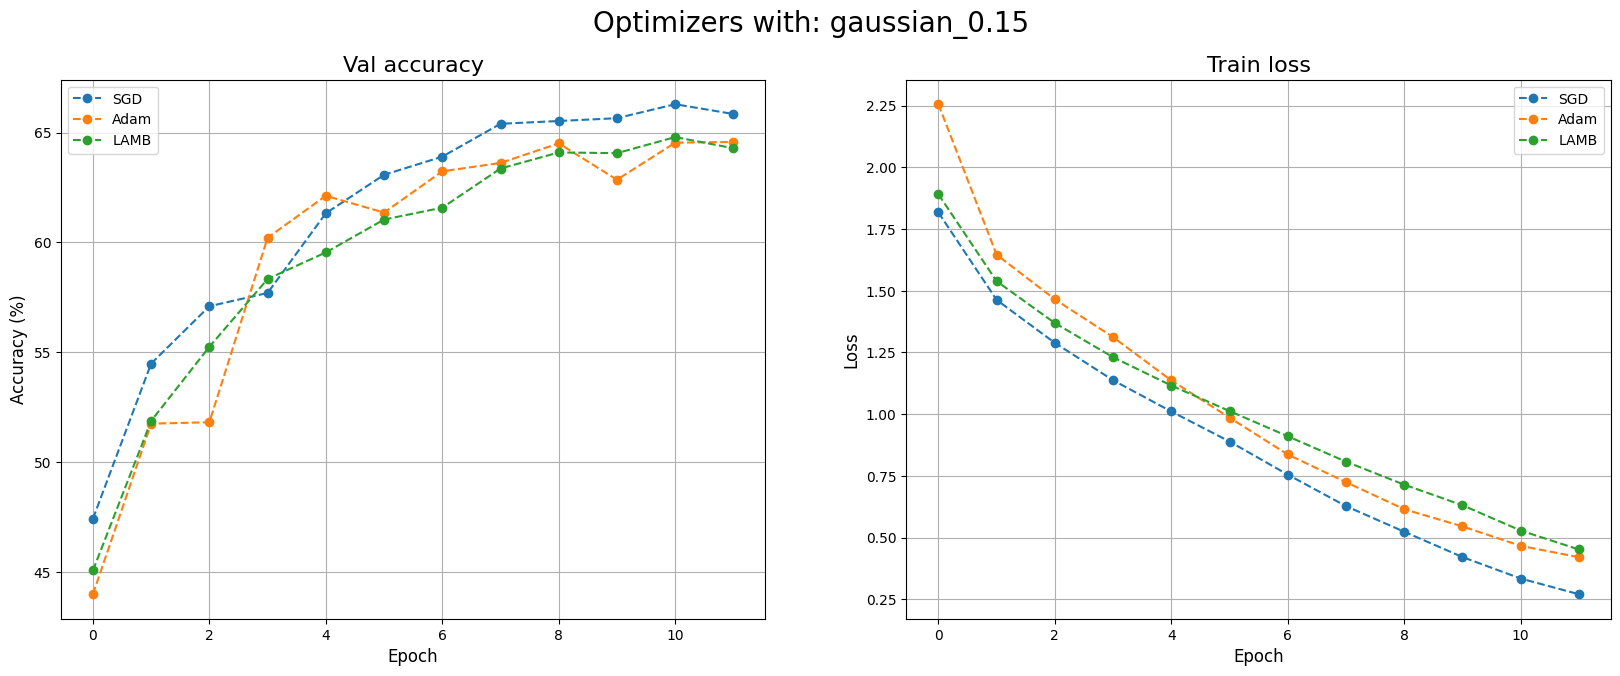

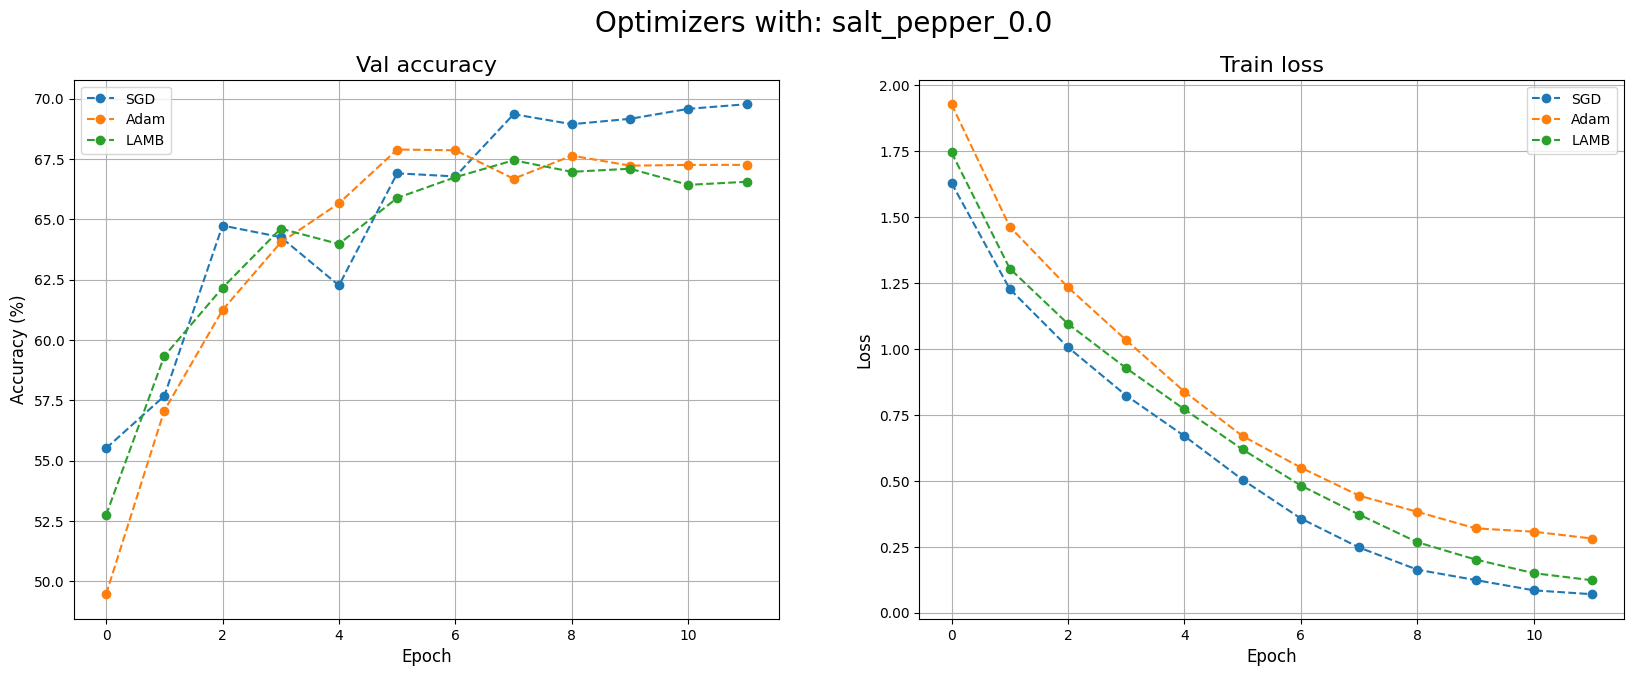

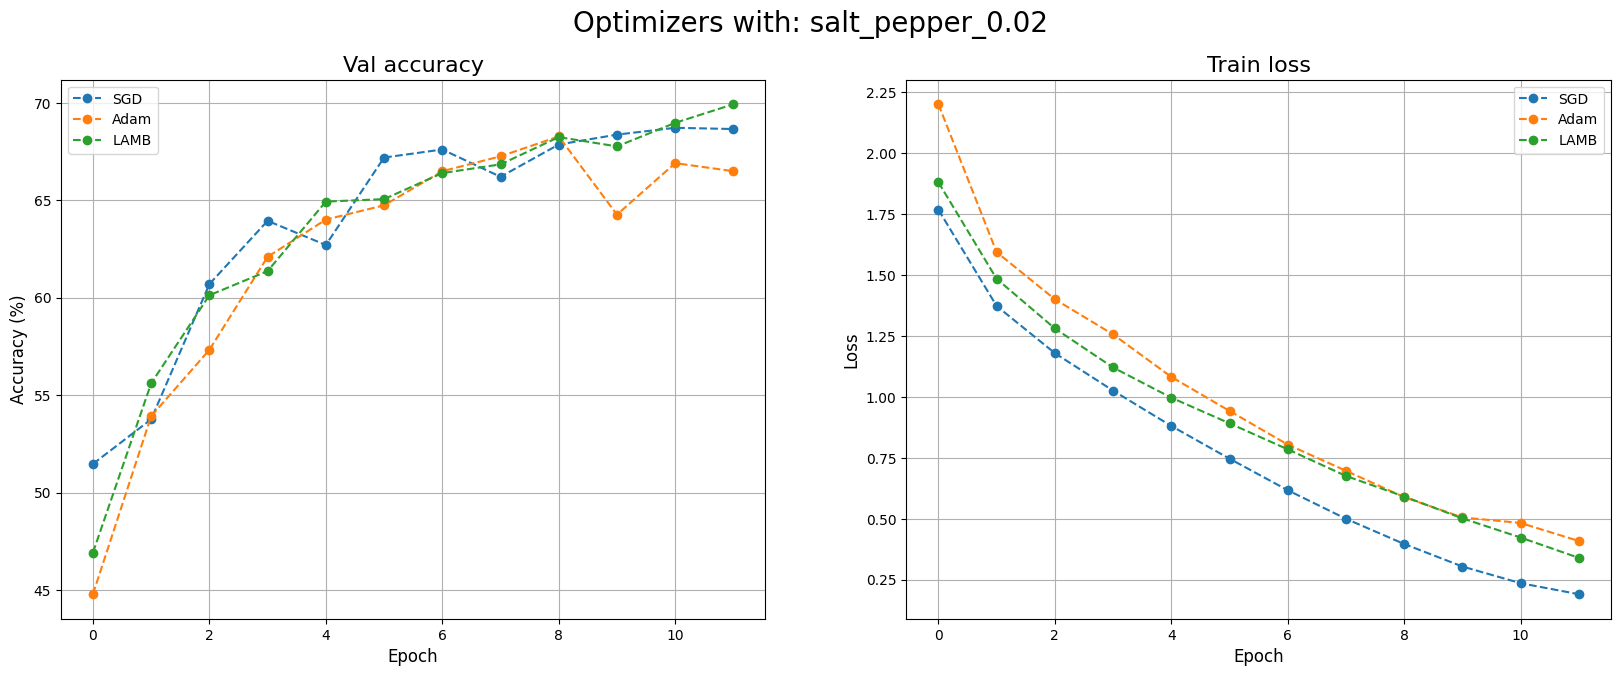

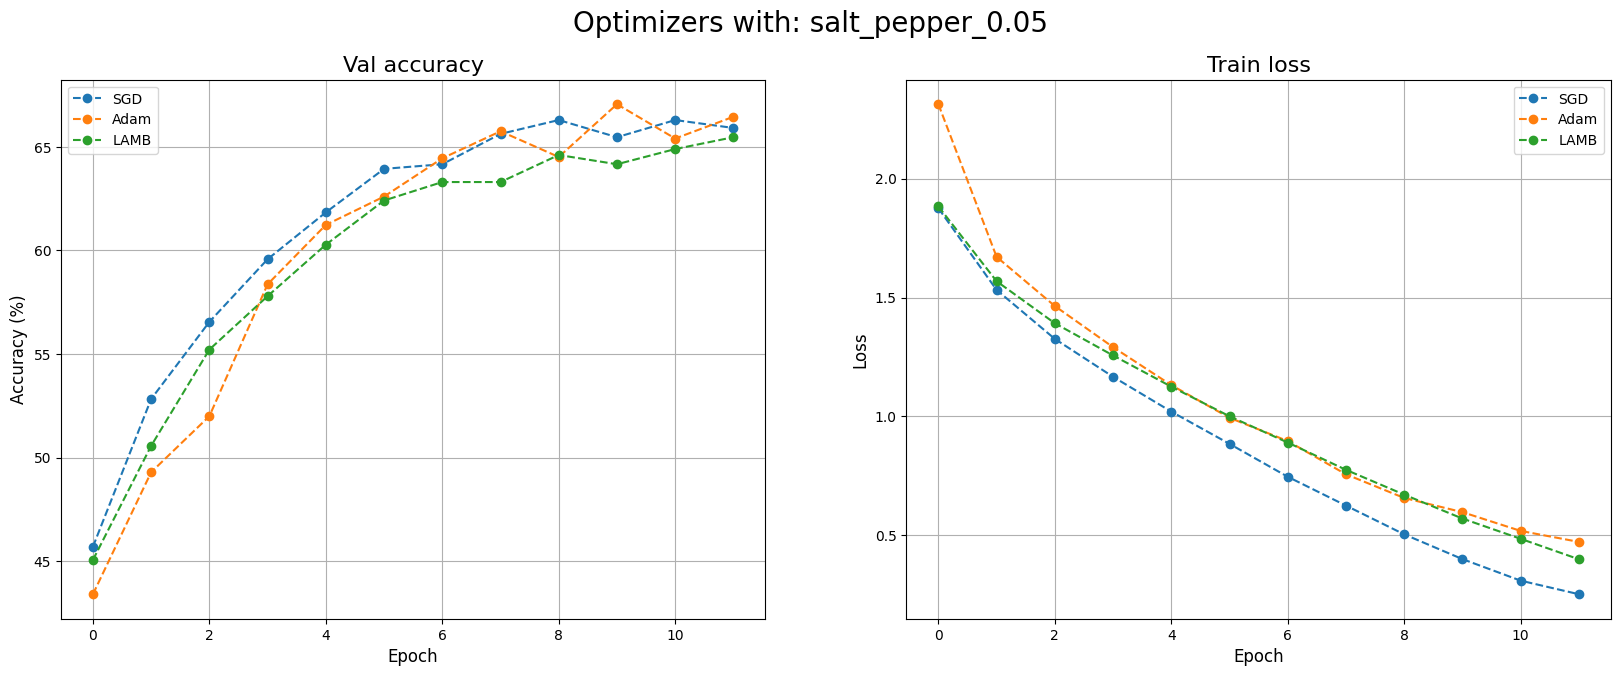

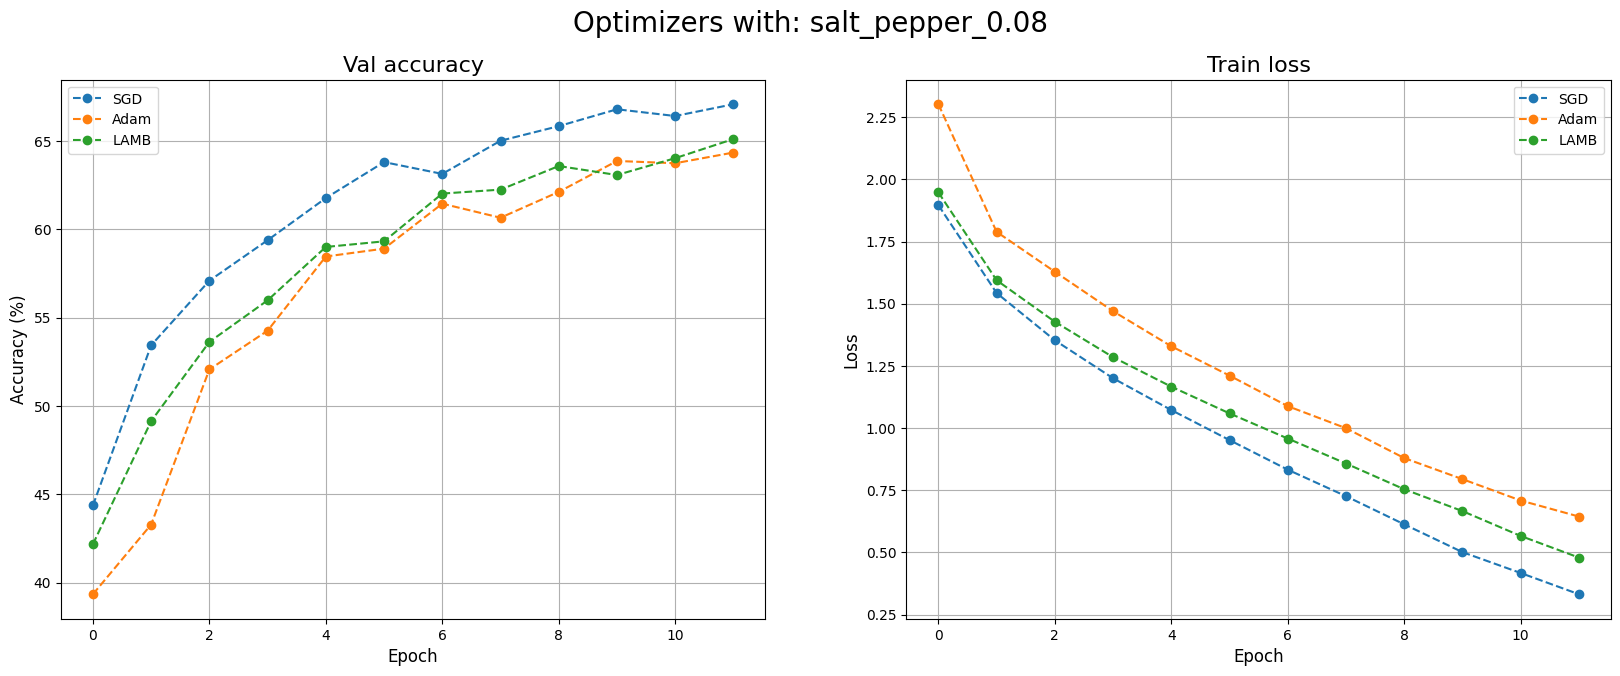

In [ ]:
plot_results_with_noise(all_results)

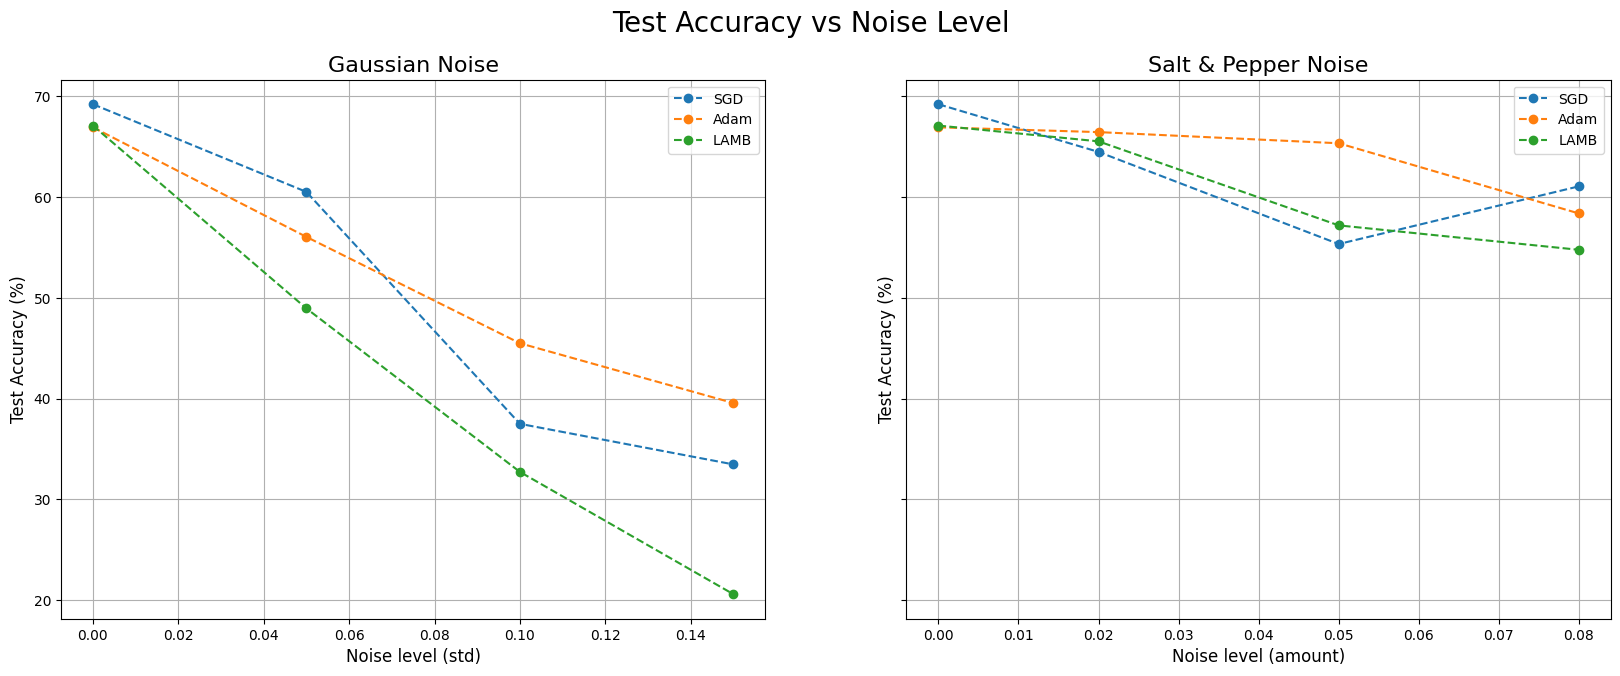

In [ ]:
plot_data = restructure_results_for_plotting(all_results)

plot_noise_vs_accuracy(plot_data)

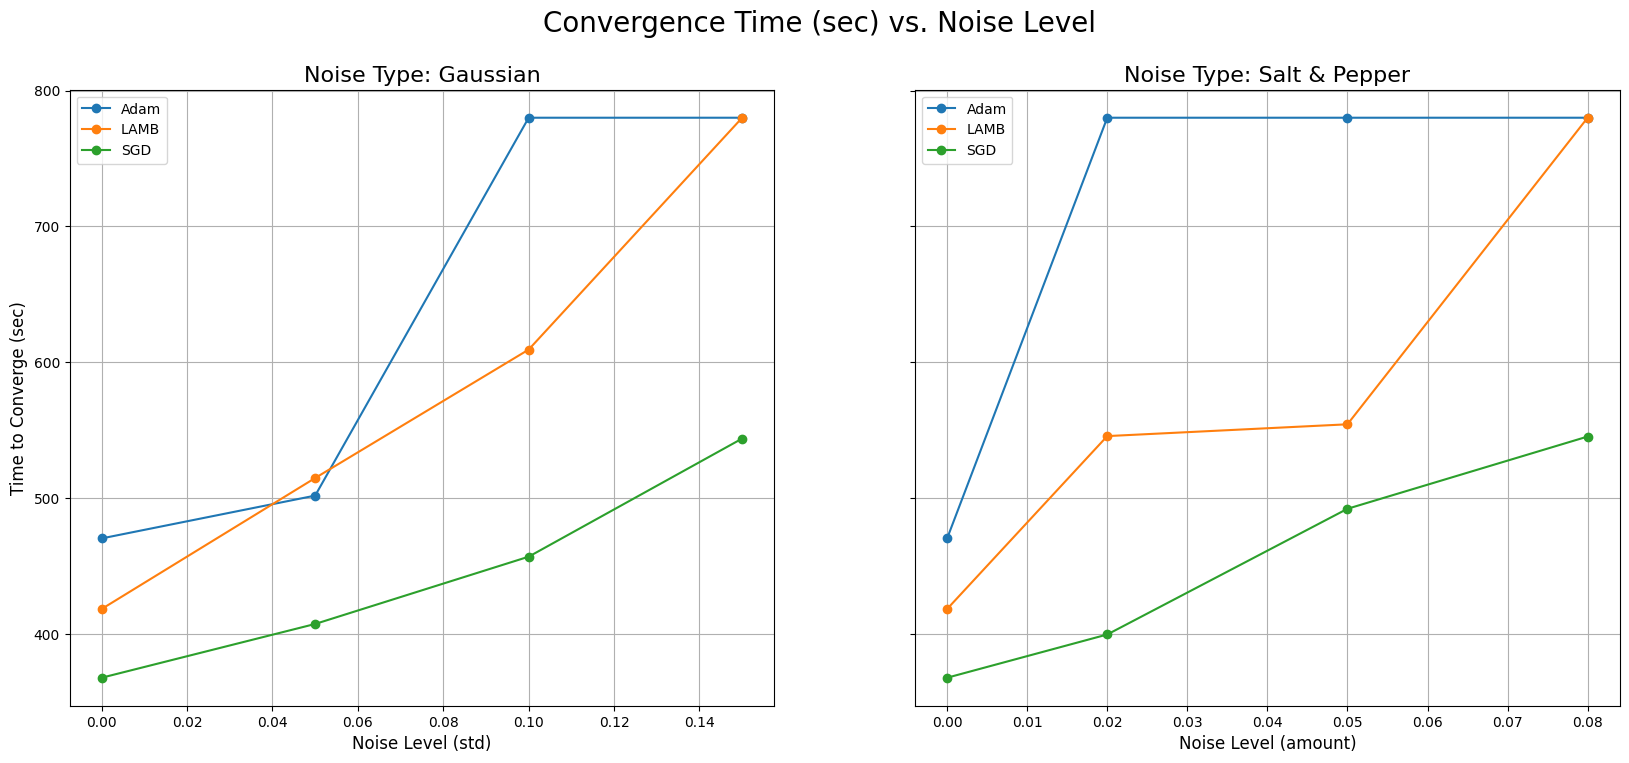

In [ ]:
plot_noise_vs_conv_time(all_results, 12)

## Исследования моделей с регуляризацией и без

In [ ]:
class CNNWithoutDropout(nn.Module):
    def __init__(self, num_classes):
        super(CNNWithoutDropout, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(16), nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(32), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1), nn.ReLU(), nn.BatchNorm2d(64), nn.MaxPool2d(2, 2)
        )
        self.classifier = nn.Sequential(
            nn.Linear(64 * 16 * 16, 512), nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [ ]:
transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            GaussianNoiseAdder(mean=0., std=0.1),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ])

train_noisy_loader, val_noisy_loader, _ = get_train_val_test_loaders('raw-img', transform, 64)

results_without_dropout, device = run_simple_experiment(CNNWithoutDropout, class_num, EPOCH_NUMBER, LEARNING_RATE, train_noisy_loader, val_noisy_loader, criterion, TARGET_LOSS)

Experiment starts on the device: cuda:0


Training with: SGD
Epoch [ 1/12], Train loss: 1.6347, Val accuracy: 50.95%
Epoch [ 2/12], Train loss: 1.2152, Val accuracy: 57.16%
Epoch [ 3/12], Train loss: 0.9780, Val accuracy: 60.44%
Epoch [ 4/12], Train loss: 0.7664, Val accuracy: 62.92%
Epoch [ 5/12], Train loss: 0.5620, Val accuracy: 63.40%
---Сonvergence was achieved in 310.67 seconds at 6 epoch---
Epoch [ 6/12], Train loss: 0.3760, Val accuracy: 65.09%
Epoch [ 7/12], Train loss: 0.2409, Val accuracy: 65.02%
Epoch [ 8/12], Train loss: 0.1442, Val accuracy: 65.28%
Epoch [ 9/12], Train loss: 0.0901, Val accuracy: 65.82%
Epoch [10/12], Train loss: 0.0593, Val accuracy: 65.72%
Epoch [11/12], Train loss: 0.0437, Val accuracy: 66.74%
Epoch [12/12], Train loss: 0.0304, Val accuracy: 67.31%

Training with: Adam
Epoch [ 1/12], Train loss: 1.8446, Val accuracy: 50.38%
Epoch [ 2/12], Train loss: 1.2319, Val accuracy: 58.47%
Epoch [ 3/12], Train loss: 0.9195, Val accuracy: 60.47%
Epoch [ 4/12], Tra

In [ ]:
for name, res_dict in results_without_dropout.items():
    final_model = CNNWithoutDropout(class_num).to(device)
    final_model.load_state_dict(res_dict["model_state"])

    test_accuracy = evaluate_model(final_model, test_loader, device)

    results_without_dropout[name]['test_accuracy'] = test_accuracy

    print(f"Test accuracy for {name}: {test_accuracy:.2f}%")

Test accuracy for SGD: 36.29%
Test accuracy for Adam: 45.59%
Test accuracy for LAMB: 46.16%


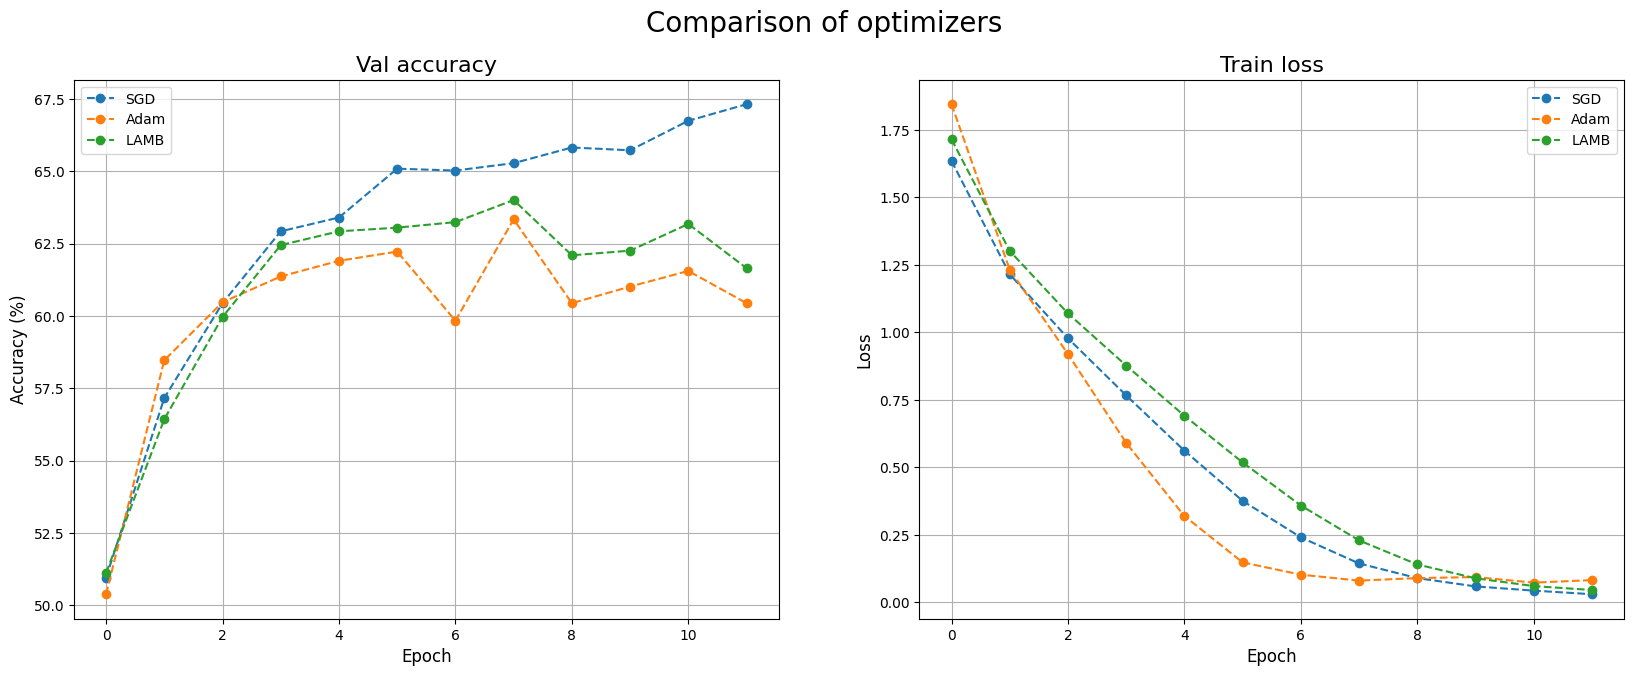

In [ ]:
plot_results(results_without_dropout)

## Добавление Weight Decay

In [ ]:
import time

def run_simple_experiment_with_weight_decay(cnn_model, class_num, epoch_number, lr, train_loader, val_loader, criterion, target_loss = 0.3):
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(f"Experiment starts on the device: {device}\n")

    results = {}

    optimizers_to_test = {"SGD": optim.SGD, "Adam": optim.Adam, "LAMB": optim_extra.Lamb}

    for name, optimizer_class in optimizers_to_test.items():
        print(f"\n{'='*30}\nTraining with: {name}\n{'='*30}")

        model = cnn_model(class_num).to(device)

        if name == "SGD":
            optimizer = optimizer_class(model.parameters(), lr, momentum=0.9, weight_decay=1e-4)
        else:
            optimizer = optimizer_class(model.parameters(), lr, weight_decay=1e-4)

        history_loss, history_val_accuracy = [], []
        convergence_time = -1

        start_time = time.time()

        for epoch in range(epoch_number):
            epoch_loss = train_one_epoch(model, optimizer, criterion, train_loader, device)
            val_accuracy = evaluate_model(model, val_loader, device)

            history_loss.append(epoch_loss)
            history_val_accuracy.append(val_accuracy)

            if epoch_loss <= target_loss and convergence_time == -1:
                convergence_time = time.time() - start_time
                print(f"---Сonvergence was achieved in {convergence_time:.2f} seconds at {epoch + 1} epoch---")

            print(f"Epoch [{epoch+1:2d}/{epoch_number}], Train loss: {epoch_loss:.4f}, Val accuracy: {val_accuracy:.2f}%")

        results[name] = {
            "accuracy": history_val_accuracy,
            "loss": history_loss,
            "final_accuracy": val_accuracy,
            "model_state": model.state_dict(),
            "convergence_time": convergence_time
        }

    return results, device

In [ ]:
results_with_weight_decay, device = run_simple_experiment_with_weight_decay(SimpleCNN, class_num, EPOCH_NUMBER, LEARNING_RATE, train_noisy_loader, val_noisy_loader, criterion, TARGET_LOSS)


Experiment starts on the device: cuda:0


Training with: SGD
Epoch [ 1/12], Train loss: 1.7822, Val accuracy: 48.82%
Epoch [ 2/12], Train loss: 1.4229, Val accuracy: 54.55%
Epoch [ 3/12], Train loss: 1.2083, Val accuracy: 58.02%
Epoch [ 4/12], Train loss: 1.0535, Val accuracy: 60.85%
Epoch [ 5/12], Train loss: 0.9004, Val accuracy: 64.19%
Epoch [ 6/12], Train loss: 0.7557, Val accuracy: 63.84%
Epoch [ 7/12], Train loss: 0.6223, Val accuracy: 63.65%
Epoch [ 8/12], Train loss: 0.4920, Val accuracy: 64.99%
---Сonvergence was achieved in 463.24 seconds at 9 epoch---
Epoch [ 9/12], Train loss: 0.3876, Val accuracy: 66.01%
Epoch [10/12], Train loss: 0.2993, Val accuracy: 66.93%
Epoch [11/12], Train loss: 0.2326, Val accuracy: 66.49%
Epoch [12/12], Train loss: 0.1820, Val accuracy: 65.88%

Training with: Adam
Epoch [ 1/12], Train loss: 2.1137, Val accuracy: 46.66%
Epoch [ 2/12], Train loss: 1.5705, Val accuracy: 51.88%
Epoch [ 3/12], Train loss: 1.4001, Val accuracy: 57.64%
Epoch [ 4/12], Tra

In [ ]:
for name, res_dict in results_with_weight_decay.items():
    final_model = SimpleCNN(class_num).to(device)
    final_model.load_state_dict(res_dict["model_state"])

    test_accuracy = evaluate_model(final_model, test_loader, device)

    results_with_weight_decay[name]['test_accuracy'] = test_accuracy

    print(f"Test accuracy for {name}: {test_accuracy:.2f}%")

Test accuracy for SGD: 51.66%
Test accuracy for Adam: 40.11%
Test accuracy for LAMB: 31.11%


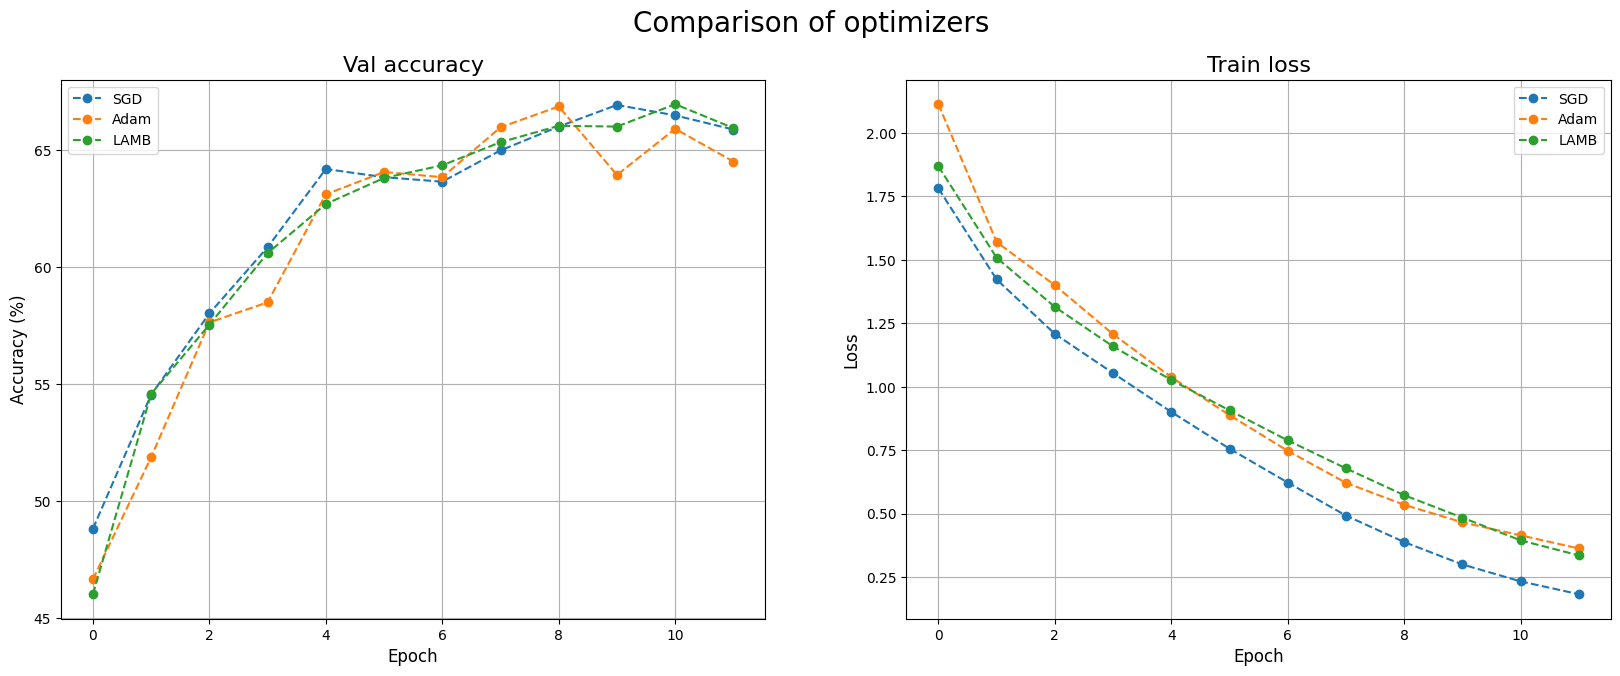

In [ ]:
plot_results(results_with_weight_decay)